In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import collections
import struct

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

from gnuradio.digital import crc

In [2]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

CLCW = BitStruct(
    'control_word_type' / Flag,
    'clcw_version_number' / BitsInteger(2),
    'status_field' / BitsInteger(3),
    'cop_in_effect' / BitsInteger(2),
    'virtual_channel_identification' / BitsInteger(6),
    'rsvd_spare' / BitsInteger(2),
    'no_rf_avail' / Flag,
    'no_bit_lock' / Flag,
    'lock_out' / Flag,
    'wait' / Flag,
    'retransmit' / Flag,
    'farm_b_counter' / BitsInteger(2),
    'rsvd_spare2' / BitsInteger(1),
    'report_value' / BitsInteger(8)
)

TMFrame = Struct(
    'primary_header' / TMPrimaryHeader,
    'm_pdu_packet_zone' / Bytes(1103),
    'clcw' / CLCW,
)

PUSHeader = BitStruct(
    'version_number' / BitsInteger(4),
    'spacecraft_time_reference_status' / BitsInteger(4),
    'service_type' / BitsInteger(8),
    'message_subtype' / BitsInteger(8),
    'message_type_counter' / BitsInteger(16),
    'destination_id' / BitsInteger(16),
)

def pus_service(pus_header):
    return (pus_header.service_type, pus_header.message_subtype)

tt_minus_utc = 69.184
sclk_t0 = np.datetime64('2000-01-01T12:00:00') + np.timedelta64(1, 'ns') * (1e9 * (7.8155681846584E+08 - tt_minus_utc))

def to_timestamp_pus(x):
    z = struct.unpack('>Q', b'\x00\x00' + x[ccsds.SpacePacketPrimaryHeader.sizeof() + PUSHeader.sizeof():][:6])[0]
    return sclk_t0 + np.timedelta64(1, 'ns') * (1e9 * z / 2**16)

def to_timestamp_time_packet(x):
    z = struct.unpack('>Q', b'\x00' + x[8:15])[0]
    return sclk_t0 + np.timedelta64(1, 'ns') * (1e9 * z / 2**24)

def to_timestamp(x):
    return sclk_t0 + x.view('uint32').byteswap().ravel() * np.timedelta64(1, 's')

source_data_offset = ccsds.SpacePacketPrimaryHeader.sizeof() + PUSHeader.sizeof() + 6 + 1

In [3]:
frame_size = 1113
frames = np.concatenate((
    np.fromfile('hera_low_rate_frames_2024_10_07_16_24_20.u8', dtype='uint8'),
    np.fromfile('hera_low_rate_frames_2024_10_07_16_25_23.u8', dtype='uint8'),
    np.fromfile('hera_high_rate_frames_2024_10_07_17_06_31.u8', dtype='uint8'),
))
frames = frames[:frames.size//frame_size*frame_size].reshape(-1, frame_size)
frames.shape

(3039, 1113)

# TM frames

Frames are TM Space Data Link frames, using spacecraft ID `0xb5`, which is
[registered to Hera in the SANA registry](https://sanaregistry.org/r/spacecraftid/records/15993). Virtual channels 1, 3, and 7 (the idle virtual channel) are in use. Frames contain an Operational Control Field and Frame Error Control Field (already stripped in GNU Radio).

In [4]:
tm = [TMFrame.parse(f) for f in frames]
scid = [a.primary_header.spacecraft_id for a in tm]
vcid = np.array([a.primary_header.virtual_channel_id for a in tm])
mcfc = np.array([a.primary_header.master_channel_frame_count for a in tm])
vcfc = np.array([a.primary_header.virtual_channel_frame_count for a in tm])
[a.primary_header for a in tm[:5]]

[Container(transfer_frame_version_number=0, spacecraft_id=181, virtual_channel_id=1, ocf_flag=True, master_channel_frame_count=15, virtual_channel_frame_count=97, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=79),
 Container(transfer_frame_version_number=0, spacecraft_id=181, virtual_channel_id=1, ocf_flag=True, master_channel_frame_count=16, virtual_channel_frame_count=98, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=119),
 Container(transfer_frame_version_number=0, spacecraft_id=181, virtual_channel_id=1, ocf_flag=True, master_channel_frame_count=17, virtual_channel_frame_count=99, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=350),
 Container(transfer_frame_version_number=0, spacecraft_id=181, virtual_channel_id=1, ocf_flag=True, master_channel_frame_count=18, virtual_channel_frame

In [5]:
collections.Counter(a.primary_header.transfer_frame_version_number for a in tm)

Counter({0: 3039})

In [6]:
collections.Counter(scid)

Counter({181: 3039})

In [7]:
collections.Counter(vcid)

Counter({np.int64(3): 1573, np.int64(1): 1044, np.int64(7): 422})

In [8]:
collections.Counter(a.primary_header.secondary_header_flag for a in tm)

Counter({False: 3039})

In [9]:
mcfc_unwrap = np.empty(frames.shape[0], 'int')
last = 0
for j in range(frames.shape[0]):
    mcfc_unwrap[j] = (mcfc[j] + (last // 256) * 256
                      if last % 256 < mcfc[j]
                      else mcfc[j] + (last // 256 + 1) * 256)
    last = mcfc_unwrap[j]

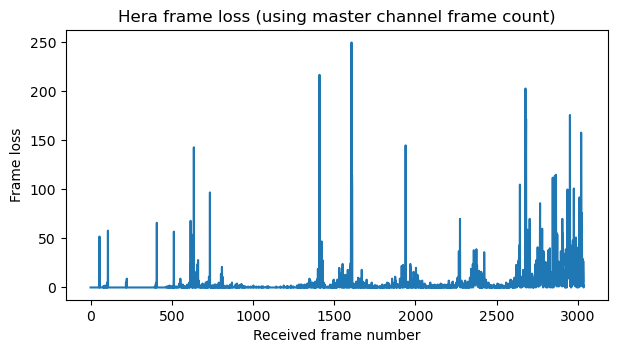

In [10]:
plt.plot(np.diff(mcfc_unwrap)-1)
plt.title('Hera frame loss (using master channel frame count)')
plt.xlabel('Received frame number')
plt.ylabel('Frame loss');

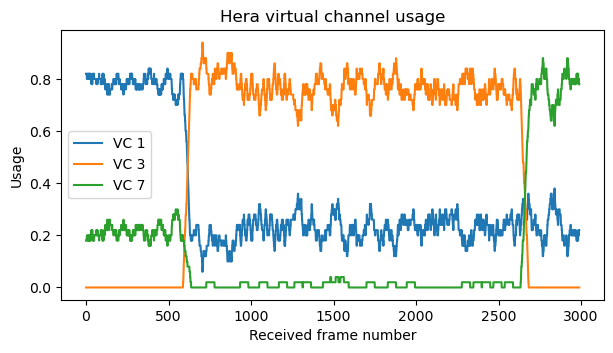

In [11]:
navg = 50
for v in sorted(set(vcid)):
    plt.plot(np.convolve(np.ones(navg)/navg, vcid == v, mode='valid'), label=f'VC {v}')
plt.legend()
plt.title('Hera virtual channel usage')
plt.xlabel('Received frame number')
plt.ylabel('Usage');

# VC1


In [12]:
vc1_packets = list(ccsds.extract_space_packets(tm, 0xb5, 1))
vc1_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc1_packets]

/home/daniel/contracting/HERA/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 181 VC 1] Broken stream. Last frame count 142, current frame count 183
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/HERA/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 181 VC 1] Broken stream. Last frame count 201, current frame count 203
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/HERA/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 181 VC 1] Broken stream. Last frame count 204, current frame count 206
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/hom

In [13]:
vc1_headers[:5]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=7204, data_length=405),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=7205, data_length=72),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=7206, data_length=141),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=7207, data_length=120),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=7208, data_length=125)]

In [14]:
vc1_apids = collections.Counter([p.APID for p in vc1_headers])
vc1_apids

Counter({260: 4169,
         264: 162,
         0: 120,
         2047: 86,
         263: 20,
         257: 15,
         256: 11,
         267: 9,
         258: 2,
         286: 2,
         291: 1})

In [15]:
collections.Counter([(p.APID, p.secondary_header_flag) for p in vc1_headers])

Counter({(260, True): 4169,
         (264, True): 162,
         (0, False): 120,
         (2047, False): 86,
         (263, True): 20,
         (257, True): 15,
         (256, True): 11,
         (267, True): 9,
         (258, True): 2,
         (286, True): 2,
         (291, True): 1})

In [16]:
vc1_by_apid = {apid: [p for p, h in zip(vc1_packets, vc1_headers) if h.APID == apid]
               for apid in vc1_apids}
vc1_t_by_apid = {apid: np.array([(to_timestamp_pus if apid != 0 else to_timestamp_time_packet)(p)
                                 for p in vc1_by_apid[apid]])
                 for apid in vc1_apids if apid not in [2047]}
vc1_pus_by_apid = {apid: [PUSHeader.parse(p[ccsds.SpacePacketPrimaryHeader.sizeof():])
                          for p in vc1_by_apid[apid]]
                   for apid in vc1_apids if apid not in [0, 2047]}
vc1_services_by_apid = {
    apid: collections.Counter([pus_service(p) for p in vc1_pus_by_apid[apid]])
    for apid in vc1_apids if apid not in [0, 2047]}

In [17]:
collections.Counter([(p.version_number, p.spacecraft_time_reference_status, p.destination_id)
                     for pus in vc1_pus_by_apid.values() for p in pus])

Counter({(2, 0, 0): 4382, (2, 0, 257): 6, (2, 0, 287): 3})

In [18]:
[apid for apid, pus in vc1_pus_by_apid.items() if any([p.destination_id != 0 for p in pus])]

[257]

In [19]:
vc1_pus_by_apid[257]

[Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=83, desti

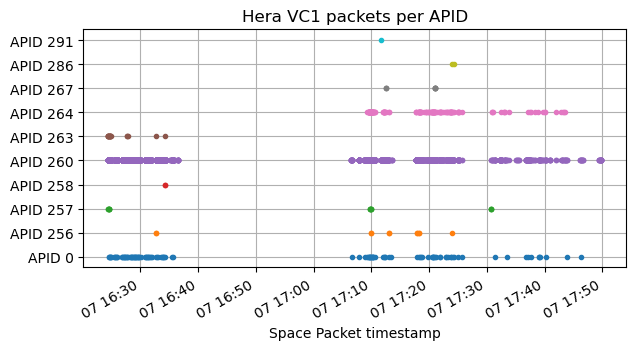

In [20]:
apid_list = sorted([a for a in vc1_apids if a not in [2047]])
for j, apid in enumerate(apid_list):
    plt.plot(vc1_t_by_apid[apid], np.ones(vc1_t_by_apid[apid].size) * j, '.'),
plt.yticks(np.arange(len(apid_list)), [f'APID {a}' for a in apid_list])
plt.grid()
plt.title('Hera VC1 packets per APID')
plt.xlabel('Space Packet timestamp')
plt.gcf().autofmt_xdate();

In [21]:
sec_avg = 100
tslices = np.datetime64('2024-10-07T16:24') + np.arange(1.45 * 3600 / sec_avg + 1) * np.timedelta64(sec_avg, 's')

In [22]:
vc1_packets_per_second = {
    apid:
    [np.sum((tslices[j] <= vc1_t_by_apid[apid]) & (vc1_t_by_apid[apid] < tslices[j+1])) / sec_avg
     for j in range(len(tslices) - 1)]
    for apid in vc1_apids if apid not in [2047]}

vc1_bytes_per_second = {
    apid:
    [np.sum([len(p) for p, t in zip(vc1_by_apid[apid], vc1_t_by_apid[apid])
             if tslices[j] <= t < tslices[j+1]]) / sec_avg
     for j in range(len(tslices) - 1)]
    for apid in vc1_apids if apid not in [2047]}

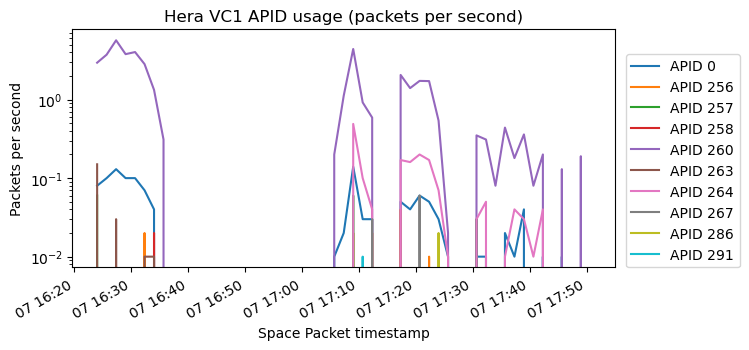

In [23]:
for j, apid in enumerate(sorted(vc1_packets_per_second)):
    plt.semilogy(tslices[:-1], vc1_packets_per_second[apid], label=f'APID {apid}',
                 linestyle='--' if j >= 10 else '-')
plt.legend(loc=[1.02,0])
plt.title('Hera VC1 APID usage (packets per second)')
plt.ylabel('Packets per second')
plt.xlabel('Space Packet timestamp')
plt.gcf().autofmt_xdate();

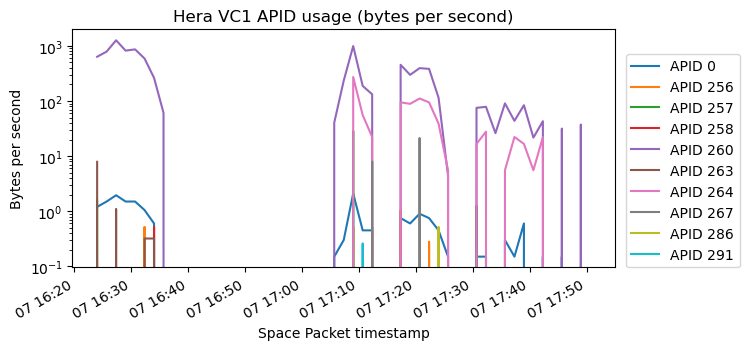

In [24]:
for j, apid in enumerate(sorted(vc1_bytes_per_second)):
    plt.semilogy(tslices[:-1], vc1_bytes_per_second[apid], label=f'APID {apid}',
                 linestyle='--' if j >= 10 else '-')
plt.legend(loc=[1.02,0])
plt.ylabel('Bytes per second')
plt.title('Hera VC1 APID usage (bytes per second)')
plt.xlabel('Space Packet timestamp')
plt.gcf().autofmt_xdate();

In [25]:
packet_crc = crc(16, 0x1021, 0xffff, 0x0, False, False)
packet_crc_ok = [packet_crc.compute(list(p[:-2])) == struct.unpack('>H', p[-2:])[0]
                 for p in vc1_packets if ccsds.SpacePacketPrimaryHeader.parse(p).APID not in [0, 2047]]
all(packet_crc_ok)

True

In [26]:
def plot_pus_service_vc1(apid):
    for j, service in enumerate(vc1_services_by_apid[apid]):
        sel = [pus_service(p) == service for p in vc1_pus_by_apid[apid]]
        plt.plot(vc1_t_by_apid[apid][sel], np.ones(np.sum(sel)) * j, '.')
    plt.yticks(np.arange(len(vc1_services_by_apid[apid])), [f'PUS {a}' for a in vc1_services_by_apid[apid]])
    plt.grid()
    plt.title(f'Hera VC1 APID {apid} packets per PUS service')
    plt.xlabel('Space Packet timestamp');

## APID 0

These packets don't contain a CRC-16.

In [27]:
collections.Counter([p[6:8].hex() for p in vc1_by_apid[0]])

Counter({'032f': 120})

In [28]:
assert all([len(a) == ccsds.SpacePacketPrimaryHeader.sizeof() + 2 + 4 + 3 for a in vc1_by_apid[0]])

## APID 256

In [29]:
vc1_services_by_apid[256]
# (1, 1) is successful acceptance verification report (request verification service)
# (1, 7) is successful completion of execution verification report (request verification service)
# (1, 2) is failed acceptance verification report

Counter({(1, 1): 5, (1, 7): 5, (1, 2): 1})

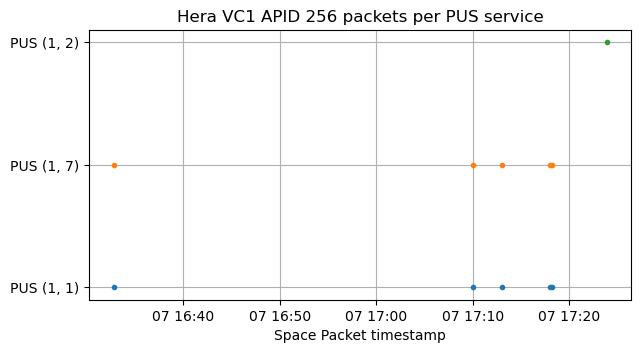

In [30]:
plot_pus_service_vc1(256)

In [31]:
vc1_pus_by_apid[256]

[Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=35, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=35, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=55, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=55, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=64, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=64, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=69, destination

In [32]:
vc1_t_by_apid[256]

array(['2024-10-07T16:32:46.331904086', '2024-10-07T16:32:46.332407626',
       '2024-10-07T17:09:58.332087192', '2024-10-07T17:09:58.332407626',
       '2024-10-07T17:12:59.332407626', '2024-10-07T17:12:59.332728061',
       '2024-10-07T17:17:58.332560214', '2024-10-07T17:17:58.332895908',
       '2024-10-07T17:18:13.333475742', '2024-10-07T17:18:13.333811435',
       '2024-10-07T17:23:53.333307895'], dtype='datetime64[ns]')

In [33]:
[a[6:].hex() for a in vc1_by_apid[256]]

['20010100230000000084e10cd1b71900faa34bd0',
 '20010700230000000084e10cf2be1900faa30489',
 '2001010037000000008d990cdd3f1900fab7bb4f',
 '2001070037000000008d990cf29d1900fab730ee',
 '2001010040000000008e4e0cf26a1900fac0e752',
 '2001070040000000008e4e0d07c81900fac04de9',
 '2001010045000000008f790cfca41900fac5d0aa',
 '2001070045000000008f790d12231900fac5ef6f',
 '2001010046000000008f880d38cd1900fac60a12',
 '2001070046000000008f880d4e5d1900fac64a65',
 '20010200010000000090dc0d2dba1900fac9001c313f']

In [34]:
# PUS (1, 1) and (1, 7) contain as payload the corresponding Space Packet header minus the data length field
# PUS (1, 2) contains as payload the corresponding Space Packet header minus the data length field followed by an error code
# (0x001c) in this case
service1_payloads = [
    ccsds.SpacePacketPrimaryHeader.parse(
        a[source_data_offset:][:ccsds.SpacePacketPrimaryHeader.sizeof() - 2]
        + b'\x00\x00')
    for a in vc1_by_apid[256]]
service1_payloads

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=256, sequence_flags=3, packet_sequence_count_or_name=15011, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=256, sequence_flags=3, packet_sequence_count_or_name=15011, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=256, sequence_flags=3, packet_sequence_count_or_name=15031, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=256, sequence_flags=3, packet_sequence_count_or_name=15031, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=256, sequence_flags=3, packet_sequence_count_or_name=15040, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=256, sequence_flags=3, packet_sequence_count_or_name=15040, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=256, sequenc

## APID 257

In [35]:
vc1_services_by_apid[257]
# (1, 1) is successful acceptance verification report (request verification service)
# (1, 7) is successful completion of execution verification report (request verification service)
# (12, 28) is functional monitoring definition status report (on-board monitoring service)
# (19, 7) is event-action status report (event-action service)
# (12, 9) is parameter monitoring definition report (on-board monitoring service)

Counter({(1, 1): 6, (1, 7): 6, (12, 28): 1, (19, 7): 1, (12, 9): 1})

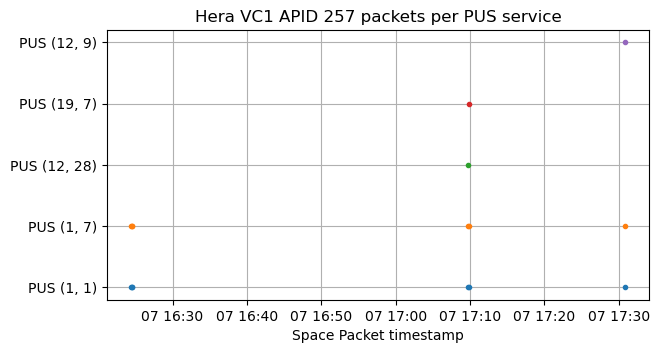

In [36]:
plot_pus_service_vc1(257)

In [37]:
vc1_pus_by_apid[257]

[Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=83, desti

In [38]:
vc1_t_by_apid[257]

array(['2024-10-07T16:24:27.327387485', '2024-10-07T16:24:27.327707919',
       '2024-10-07T16:24:29.327463779', '2024-10-07T16:24:29.327829990',
       '2024-10-07T16:24:31.327097568', '2024-10-07T16:24:31.327463779',
       '2024-10-07T17:09:46.328364047', '2024-10-07T17:09:46.336786899',
       '2024-10-07T17:09:46.337488803', '2024-10-07T17:09:52.330393466',
       '2024-10-07T17:09:52.331431064', '2024-10-07T17:09:52.332407626',
       '2024-10-07T17:30:46.327677402', '2024-10-07T17:30:46.328043613',
       '2024-10-07T17:30:46.328333530'], dtype='datetime64[ns]')

In [39]:
service1_payloads_apid257 = [
    ccsds.SpacePacketPrimaryHeader.parse(
        a[source_data_offset:][:ccsds.SpacePacketPrimaryHeader.sizeof() - 2]
        + b'\x00\x00')
    for a, p in zip(vc1_by_apid[257], vc1_pus_by_apid[257]) if p.service_type == 1]
service1_payloads_apid257

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=1, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=1, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=2, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=2, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=3, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=3, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequen

In [40]:
tm_12_9_packet = [a for a, p in zip(vc1_by_apid[257], vc1_pus_by_apid[257])
                   if pus_service(p) == (12, 9)][0]
n_pmon = struct.unpack('>I', tm_12_9_packet[source_data_offset:][:4])[0]
assert n_pmon == 1

In [41]:
tm_12_9_packet[source_data_offset+4:-2].hex()

'045a333e1e4400000000000000ff0000000000000002000100000601c03900000000000009d9405040000000000009d9'

In [42]:
# some guesswork

# this is PMON ID + monitored parameter ID + parameter validity ID
# (unclear how to break them up)
tm_12_9_packet[source_data_offset+4:][:7].hex()

'045a333e1e4400'

In [43]:
# this is the mask of check validity condition
tm_12_9_packet[source_data_offset+4+7:][:8].hex()

'000000000000ff00'

In [44]:
# this is the expected value of check validity condition
tm_12_9_packet[source_data_offset+4+7+8:][:8].hex()

'0000000000000200'

In [45]:
# this is the PMON status
tm_12_9_packet[source_data_offset+4+7+8*2:][:1].hex()

'01'

In [46]:
# this is the repetition number
tm_12_9_packet[source_data_offset+4+7+8*2+1:][:3].hex()

'000006'

In [47]:
# this is the check type, which is limit-checking
tm_12_9_packet[source_data_offset+4+7+8*2+1+3:][:1].hex()

'01'

In [48]:
# these are the limits
limits = np.frombuffer(tm_12_9_packet[source_data_offset+4+7+8*2+1+3+1:-2], 'uint8').reshape(2, 10)
limits[:, :8].view('>f8')

array([[-25.],
       [ 65.]], dtype='>f8')

In [49]:
[hex(a) for a in limits[:, -2:].view('>u2').ravel()]

['0x9d9', '0x9d9']

In [50]:
tm_12_28_packet = [a for a, p in zip(vc1_by_apid[257], vc1_pus_by_apid[257])
                   if pus_service(p) == (12, 28)][0]
n_fmon = struct.unpack('>I', tm_12_28_packet[source_data_offset:][:4])[0]
fmons = np.frombuffer(tm_12_28_packet[source_data_offset+4:-2], 'uint8').reshape(n_fmon, 5)
fmon_id = fmons[:, :2].view('>u2').ravel()
fmon_protection_status = fmons[:, 2] # 0 = unprotected, 1 = protected
fmon_status = fmons[:, 3] # 0 = disabled, 1 = enabled
fmon_checking_status = fmons[:, 4] # 0 = unchecked, 1 = running, 2 = invalid, 3 = failed

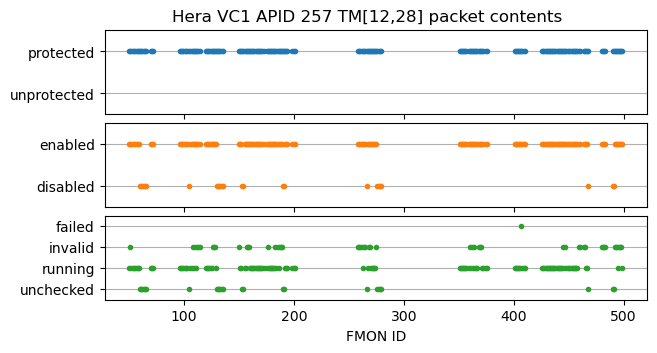

In [51]:
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(fmon_id, fmon_protection_status, '.', color='C0', label='protection status')
axs[0].set_yticks([0, 1], ['unprotected', 'protected'])
axs[0].set_ylim(-0.5, 1.5)
axs[1].plot(fmon_id, fmon_status, '.', color='C1', label='status')
axs[1].set_yticks([0, 1], ['disabled', 'enabled'])
axs[1].set_ylim(-0.5, 1.5)
axs[2].plot(fmon_id, fmon_checking_status, '.', color='C2', label='checking status')
axs[2].set_yticks(range(4), ['unchecked', 'running', 'invalid', 'failed'])
axs[2].set_ylim(-0.5, 3.5)
for ax in axs:
    ax.grid(axis='y')
axs[-1].set_xlabel('FMON ID')
plt.subplots_adjust(hspace=0.1)
plt.suptitle('Hera VC1 APID 257 TM[12,28] packet contents', y=0.94);

In [52]:
tm_19_7_packet = [a for a, p in zip(vc1_by_apid[257], vc1_pus_by_apid[257])
                  if pus_service(p) == (19, 7)][0]
n_event = struct.unpack('>I', tm_19_7_packet[source_data_offset:][:4])[0]
events = np.frombuffer(tm_19_7_packet[source_data_offset+4:-2], 'uint8').reshape(n_event, 5)
event_apid = events[:, :2].view('>u2').ravel()
event_definition_id = events[:, 2:4].view('>u2').ravel()
event_status = events[:, 4]

In [53]:
event_apid

array([ 263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  263,  263,  263,  263,
        263,  263,  263,  263,  263,  263,  263,  2

In [54]:
event_definition_id

array([    6,   215,   226,   227,   228,   229,   230,   231,   232,
         233,   234,   235,   239,   240,   241,   242,   244,   245,
         246,   248,   249,   250,   251,   252,   253,   259,   273,
         274,   291,   292,   300,   301,   345,   356,   357,   358,
         359,   365,   371,   375,   399,   400,   406,   452,   482,
         500,   508,   517,   547,   548,   556,   557,   558,   575,
         576,   577,   579,   580,   588,   591,   599,   602,   620,
         708,   709,   712,   715,  1249,  1250,  1251,  1252,  1253,
        1254,  1256,  1257,  1258,  1259,  1260,  1261,  1262,  1268,
        1269,  1270,  1271,  1272,  1321,  1324,  1325,  1326,  1327,
        1330,  1331,  1332,  1333,  1334,  1335,  1336,  1337,  1338,
        1339,  1340,  1343,  1351,  1352,  1353,  1354,  1355,  1356,
        1357,  1358,  1365,  1366,  1367,  1368,  1369,  1370,  1371,
        1374,  1385,  1387,  1389,  1391,  1405,  1406,  1407,  1408,
        1409,  1410,

In [55]:
event_status

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,

## APID 258

In [56]:
vc1_services_by_apid[258]
# (1, 1) is successful acceptance verification report (request verification service)
# (1, 7) is successful completion of execution verification report (request verification service)

Counter({(1, 1): 1, (1, 7): 1})

In [57]:
service1_payloads_apid258 = [
    ccsds.SpacePacketPrimaryHeader.parse(
        a[source_data_offset:][:ccsds.SpacePacketPrimaryHeader.sizeof() - 2]
        + b'\x00\x00')
    for a in vc1_by_apid[258]]
service1_payloads_apid258

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=258, sequence_flags=3, packet_sequence_count_or_name=12809, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=258, sequence_flags=3, packet_sequence_count_or_name=12809, data_length=0)]

In [58]:
vc1_t_by_apid[258]

array(['2024-10-07T16:34:19.328501376', '2024-10-07T16:34:19.328821811'],
      dtype='datetime64[ns]')

## APID 260

In [59]:
vc1_services_by_apid[260]
# (3, 25) is housekeeping parameter report (housekeeping service)

Counter({(3, 25): 4169})

In [60]:
hk_sid = np.array([np.frombuffer(a[source_data_offset:][:2], 'uint8') for a in vc1_by_apid[260]]).view('>u2').ravel()
sids = collections.Counter([int(a) for a in hk_sid])
sids

Counter({81: 609,
         110: 300,
         80: 169,
         62: 167,
         12: 164,
         61: 161,
         10: 160,
         83: 160,
         15: 160,
         33: 160,
         11: 159,
         40: 156,
         111: 151,
         13: 150,
         31: 150,
         14: 149,
         21: 147,
         22: 147,
         32: 147,
         112: 143,
         1: 140,
         50: 133,
         41: 44,
         105: 38,
         106: 31,
         2: 31,
         39: 21,
         35: 8,
         36: 7,
         37: 5,
         103: 1,
         104: 1})

In [61]:
{sid: {len(a[source_data_offset+2:-2]) for a in vc1_by_apid[260]
       if struct.unpack('>H', a[source_data_offset:][:2])[0] == sid}
 for sid in sids}

{39: {388},
 41: {55},
 61: {124},
 80: {103},
 62: {108},
 81: {96},
 10: {101},
 83: {104},
 11: {69},
 12: {45},
 13: {284},
 105: {712},
 14: {192},
 106: {537},
 1: {408},
 15: {91},
 21: {162},
 22: {172},
 31: {261},
 32: {377},
 110: {296},
 33: {216},
 111: {144},
 112: {241},
 50: {461},
 40: {189},
 2: {484},
 35: {247},
 36: {295},
 37: {1577},
 103: {320},
 104: {720}}

/tmp/ipykernel_57106/2757032553.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


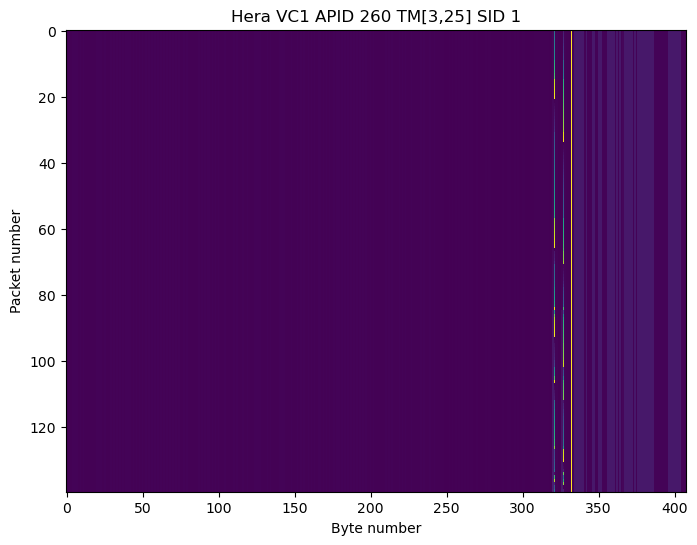

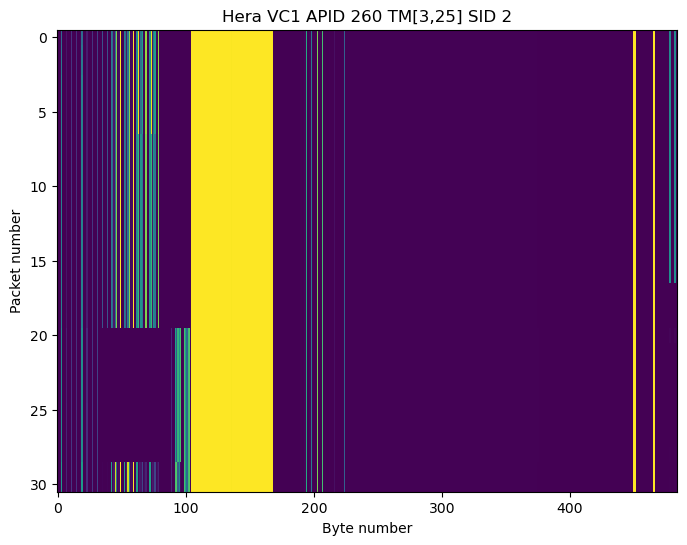

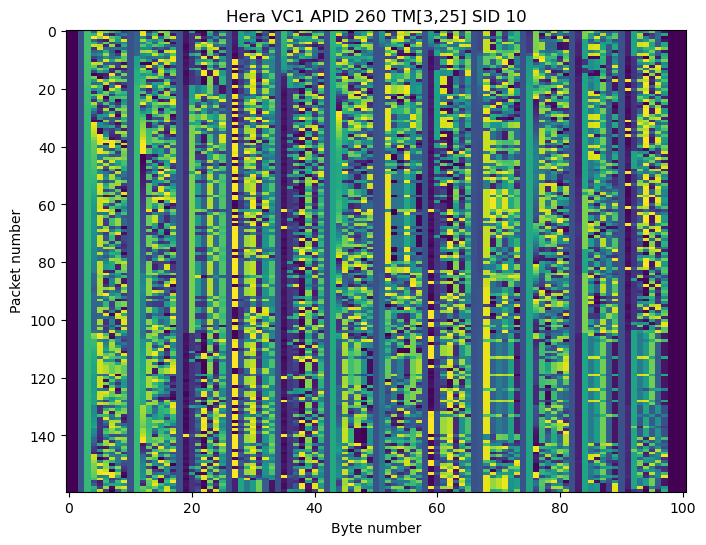

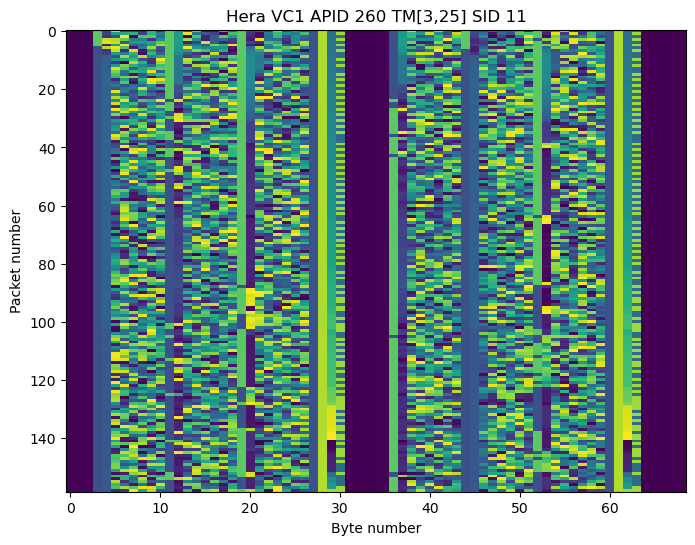

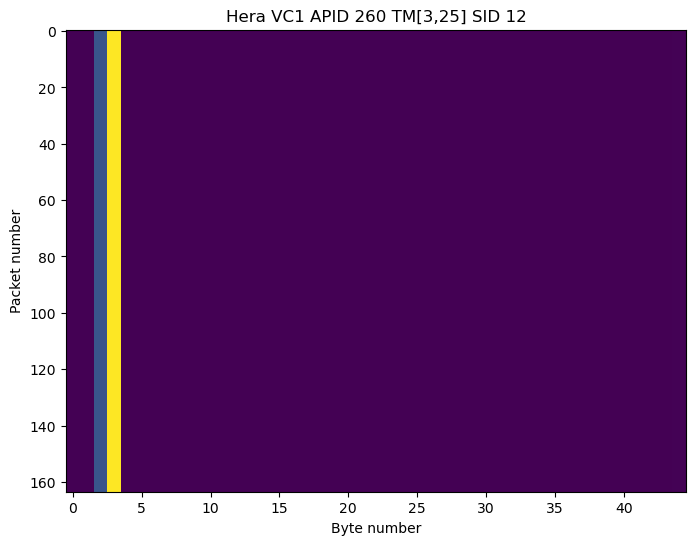

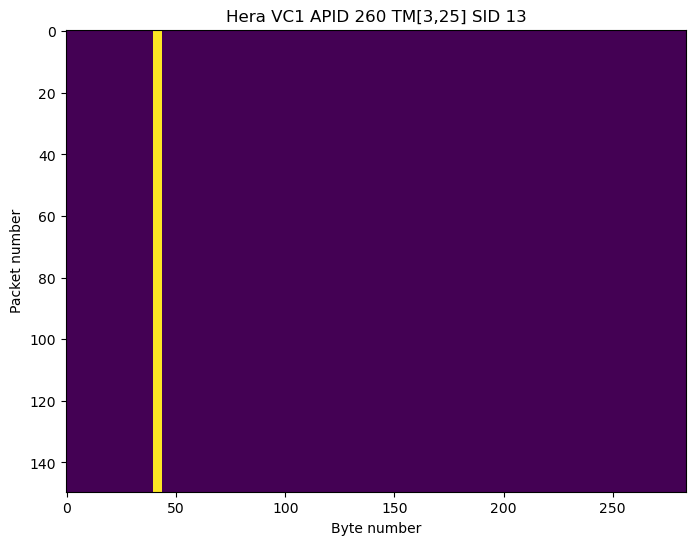

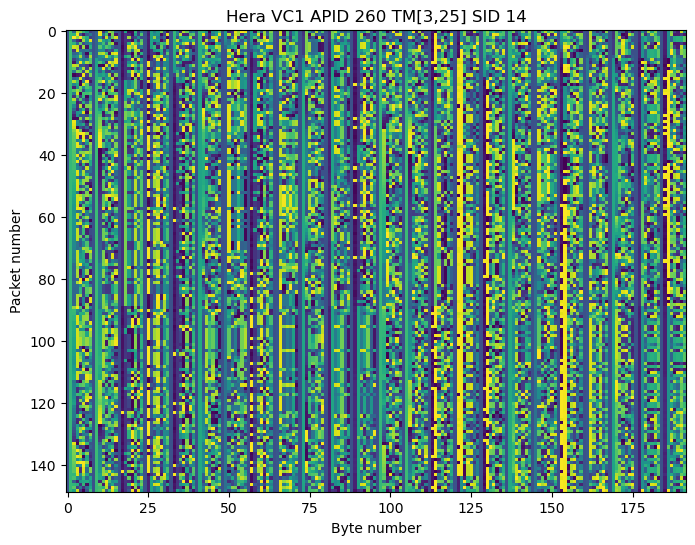

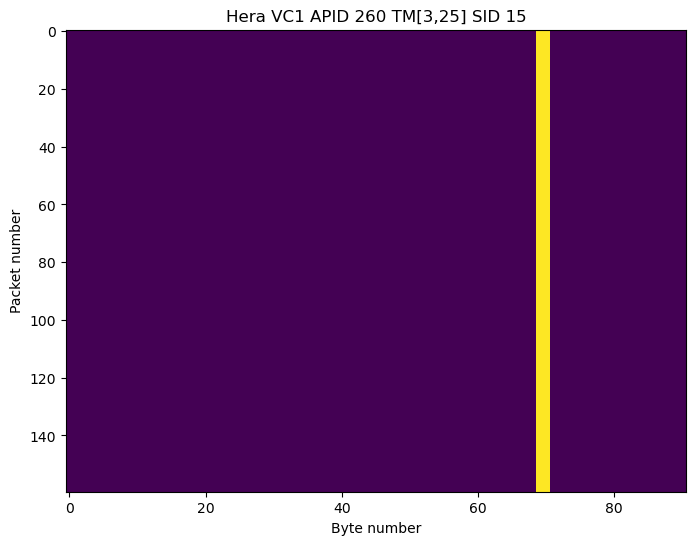

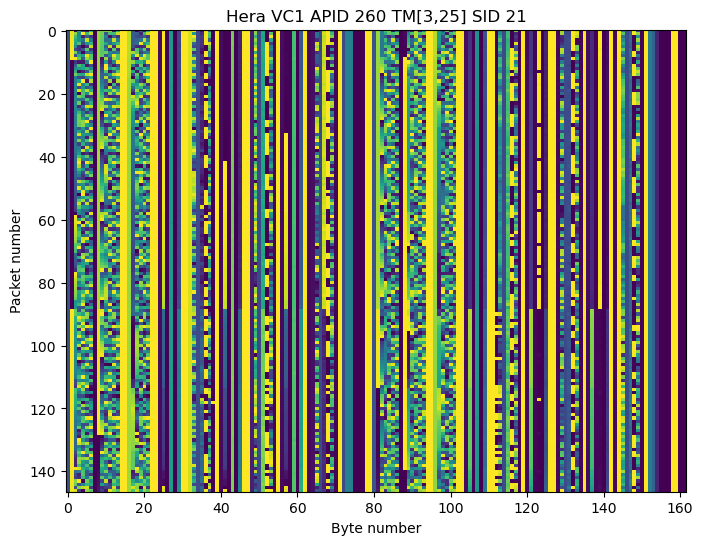

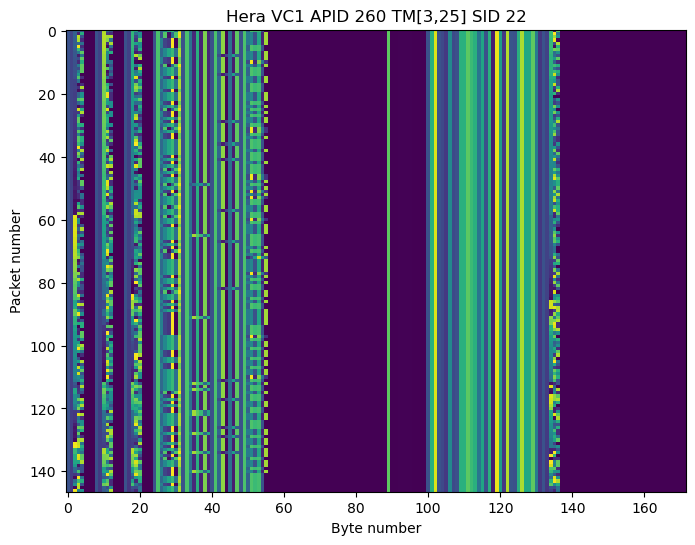

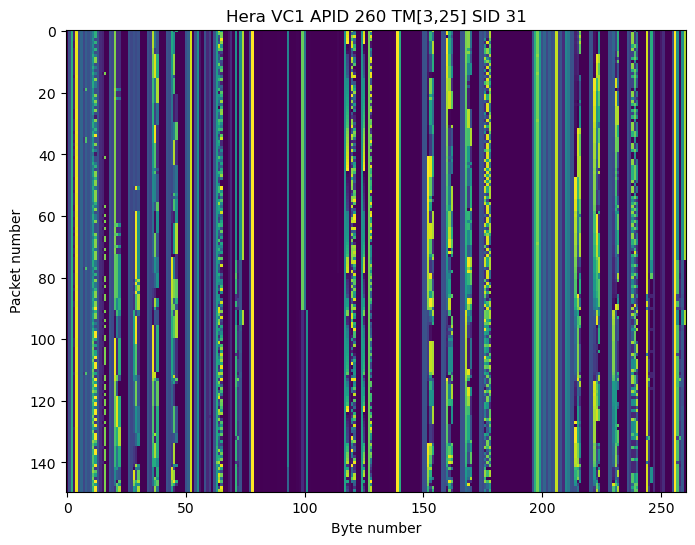

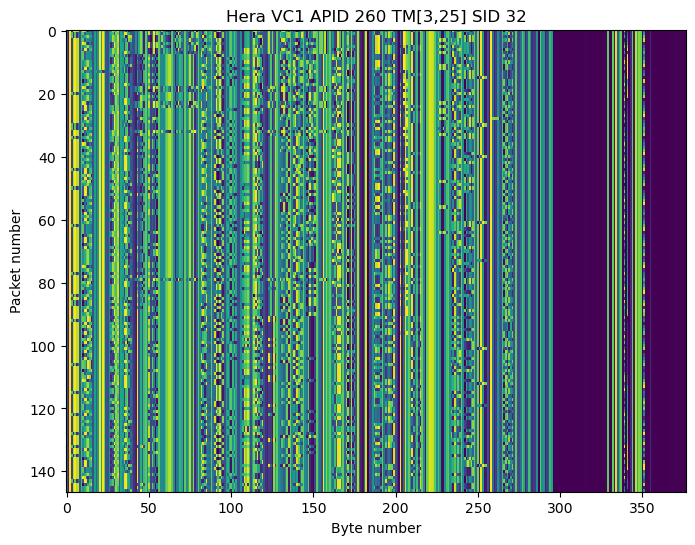

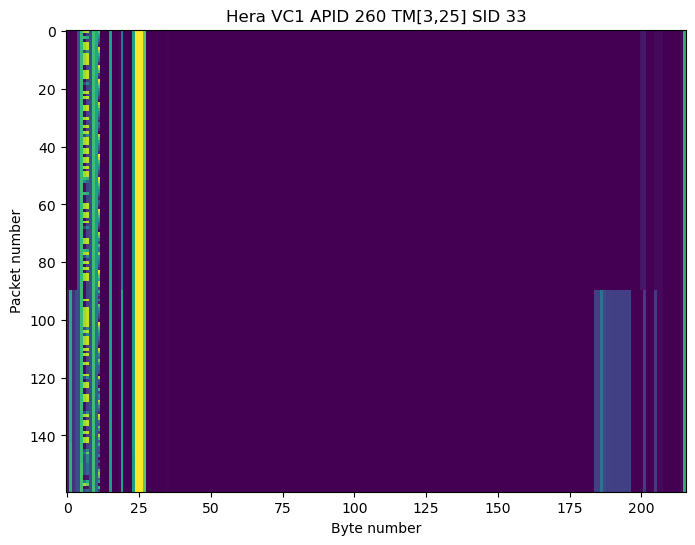

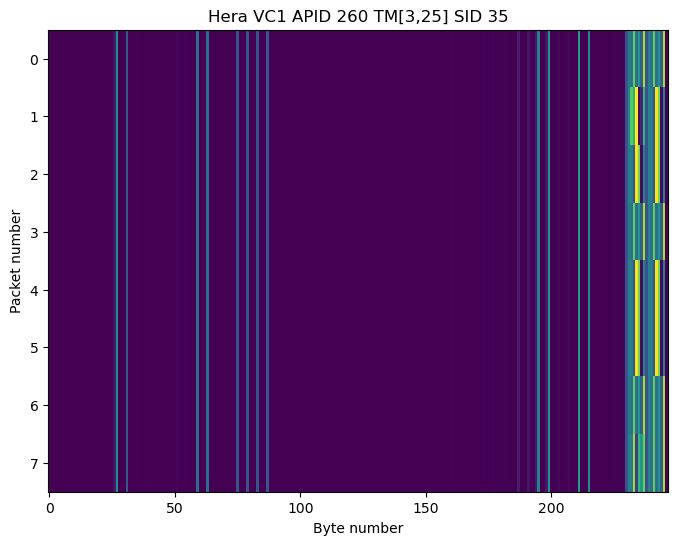

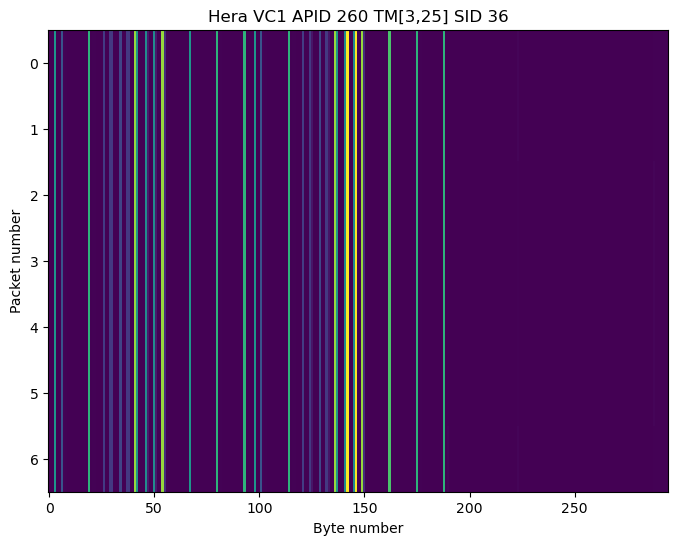

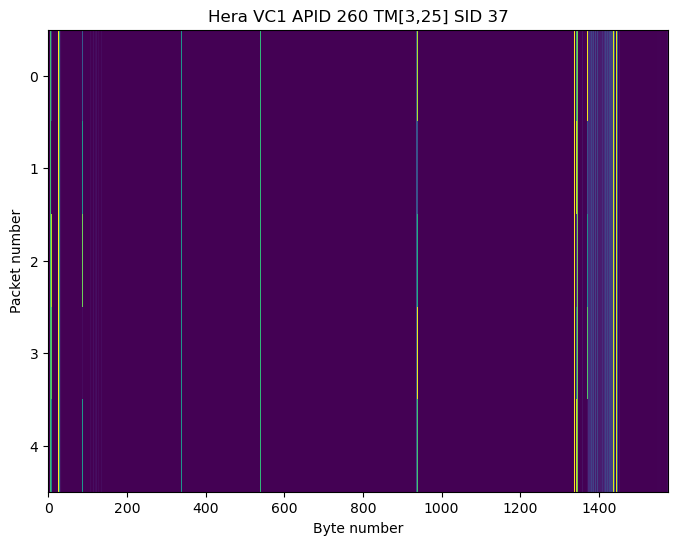

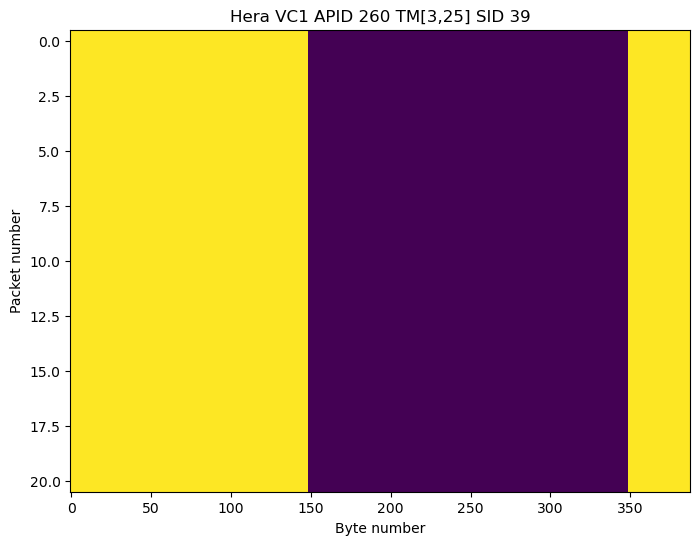

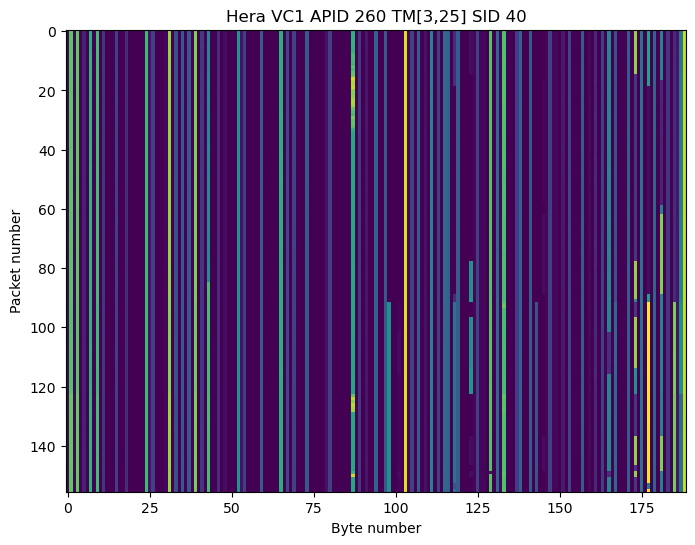

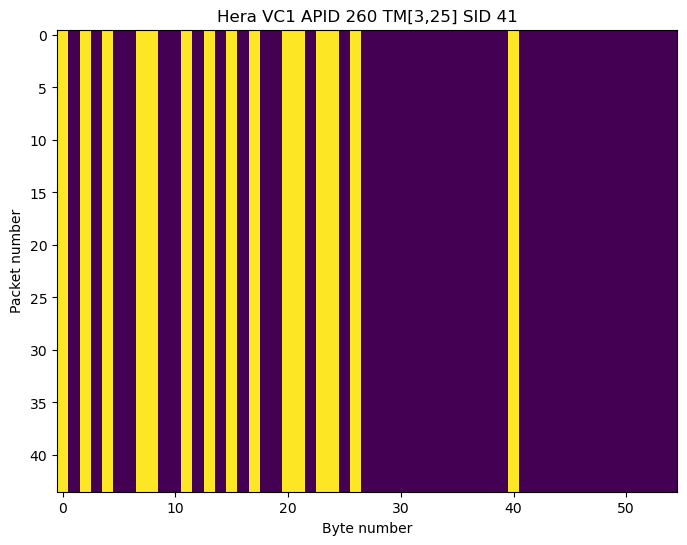

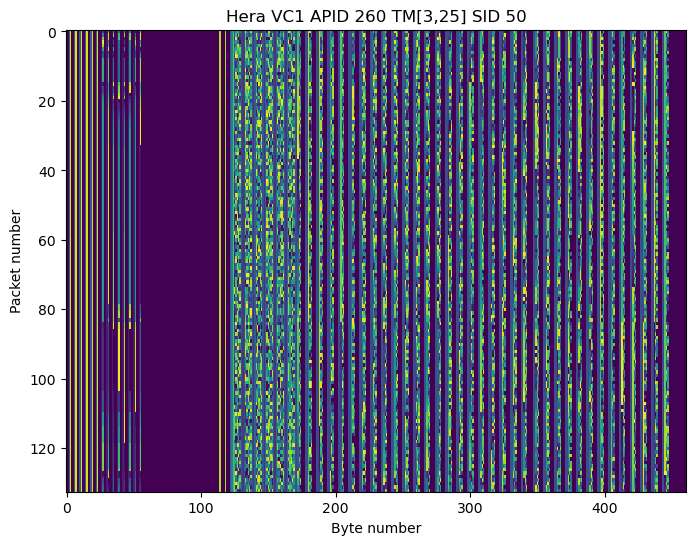

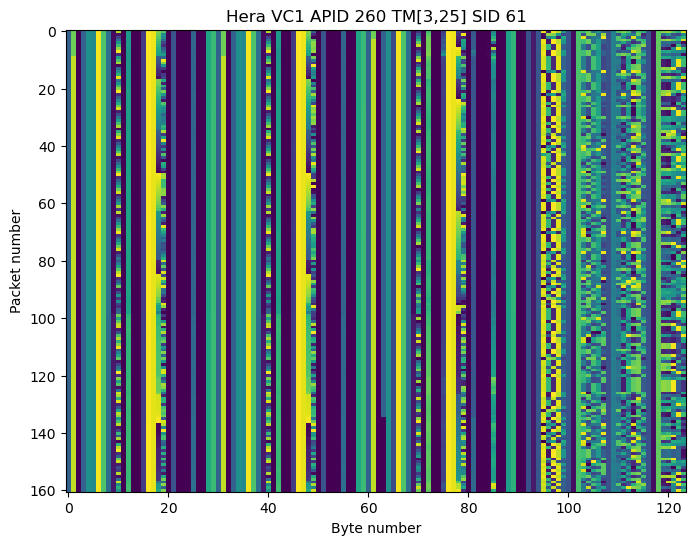

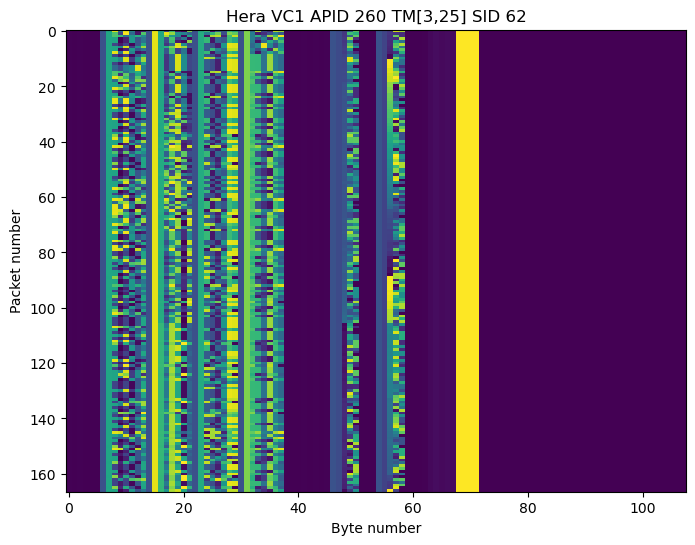

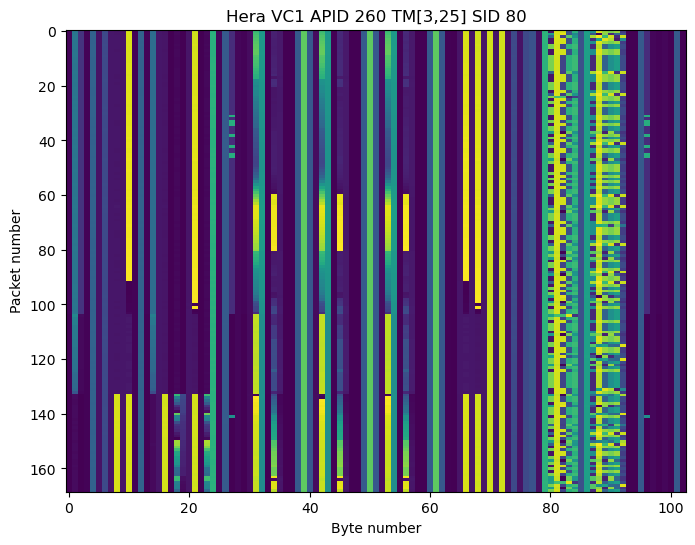

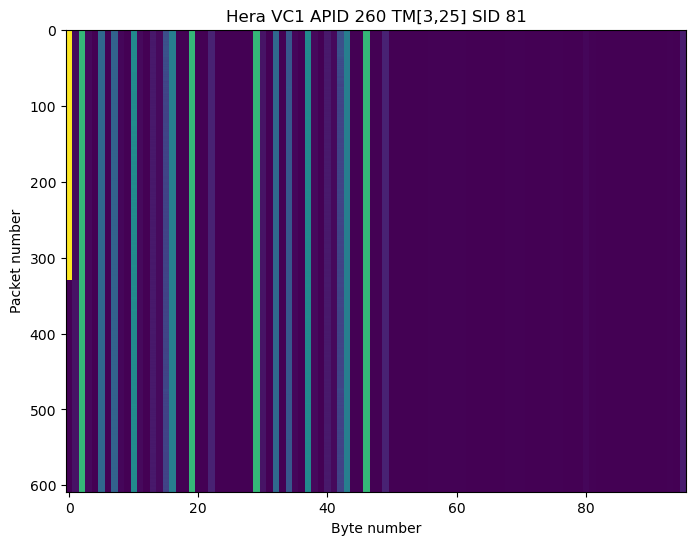

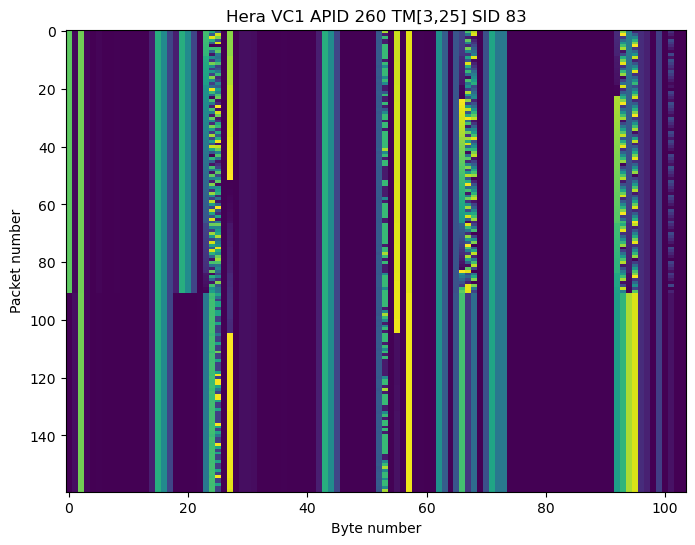

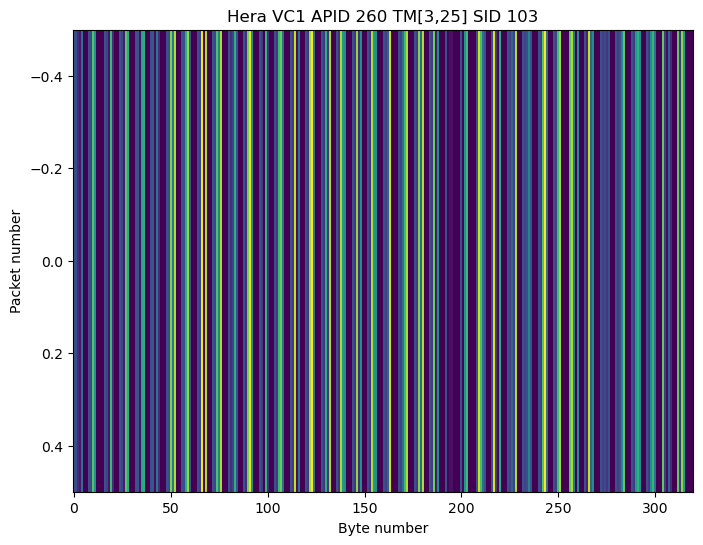

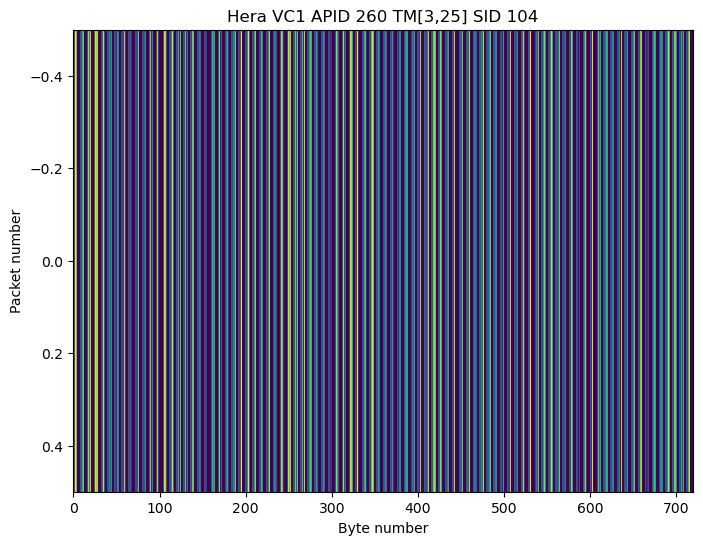

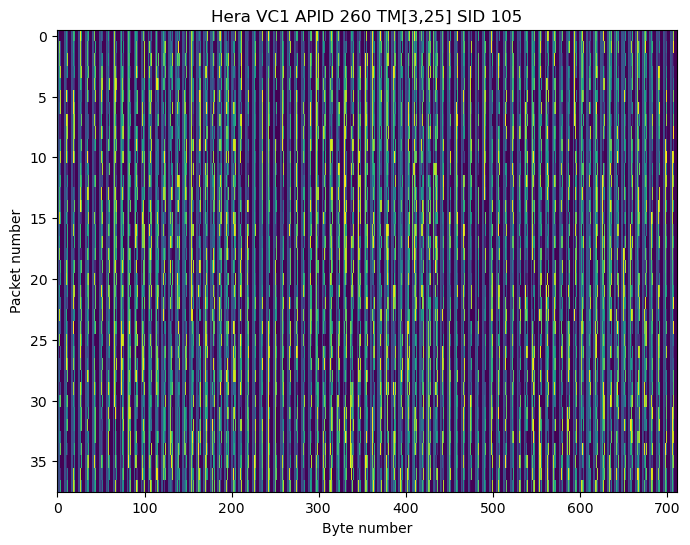

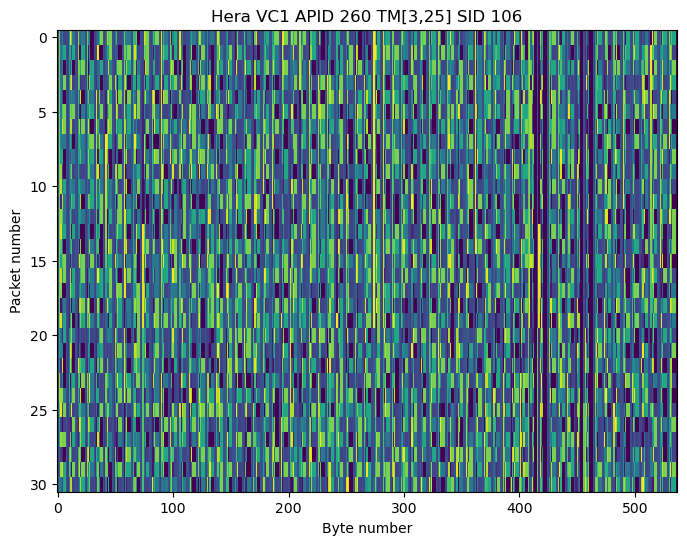

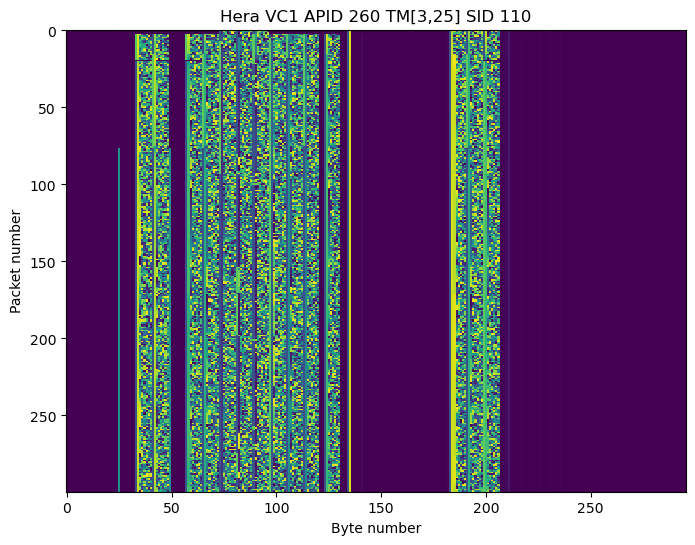

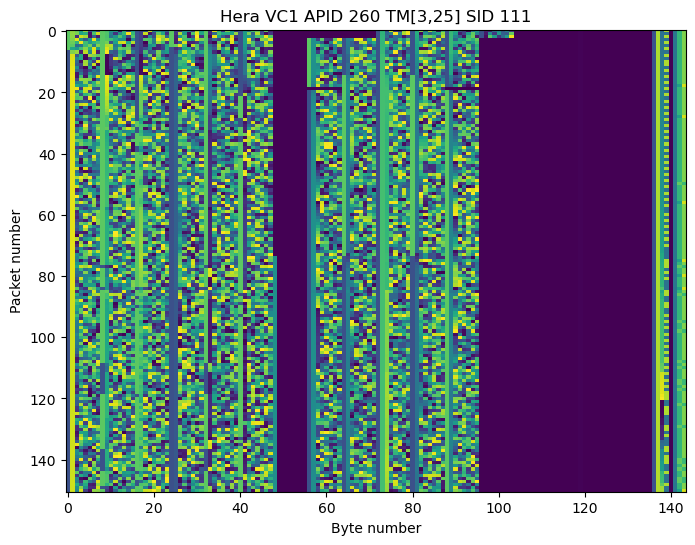

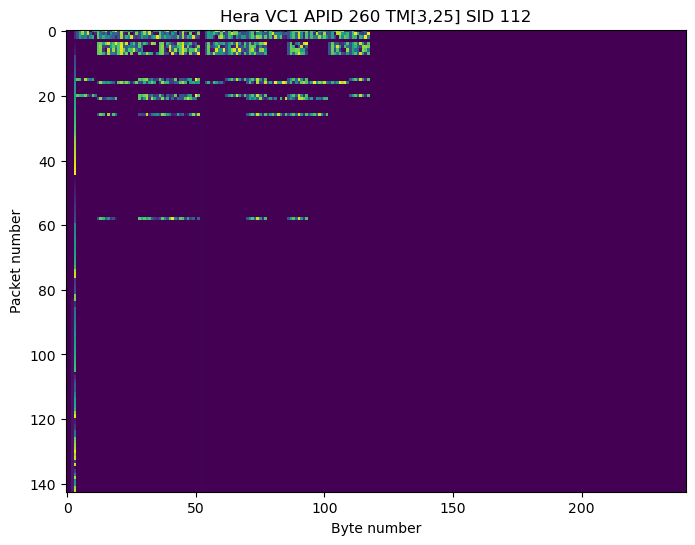

In [62]:
vc1_tm_3_25 = {}
vc1_tm_3_25_t = {}
for sid in sorted(sids):
    data = np.array([np.frombuffer(a[source_data_offset+2:-2], 'uint8') for a in vc1_by_apid[260]
                     if struct.unpack('>H', a[source_data_offset:][:2])[0] == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(data, aspect='auto', interpolation='none')
    plt.title(f'Hera VC1 APID 260 TM[3,25] SID {sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')
    vc1_tm_3_25[sid] = data
    vc1_tm_3_25_t[sid] = np.array([t for t, a in zip(vc1_t_by_apid[260], vc1_by_apid[260])
                                   if struct.unpack('>H', a[source_data_offset:][:2])[0] == sid])

In [63]:
def plot_tlm(sid, sel, *, vc=1, apid=260, fmt='float64', minus_avg=False):
    assert vc in [1, 3]
    t = (vc1_tm_3_25_t if vc == 1 else vc3_tm_3_25_t)[sid]
    dat = (vc1_tm_3_25 if vc == 1 else vc3_tm_3_25)[sid]
    x = dat[:, sel]
    dtype = {'float64': '>f8', 'int64': '>i8'}[fmt]
    x = x.view(dtype)
    if minus_avg:
        x = x - np.average(x, axis=0)
    byterange = np.arange(dat.shape[1])[sel]
    plt.plot(t, x, '.')
    plt.gcf().autofmt_xdate()
    minavg = ' (average removed)' if minus_avg else ''
    plt.title(f'Hera VC{vc} APID {apid} TM[3,25] SID {sid} bytes {byterange[0]}-{byterange[-1]+1}{minavg}')
    plt.xlabel('Space Packet timestimestamp')
    plt.ylabel(f'Value ({fmt})')

### SID 10

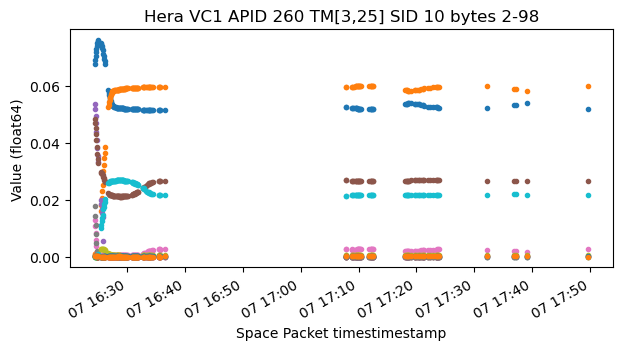

In [64]:
plot_tlm(10, slice(2, -3))

### SID 11

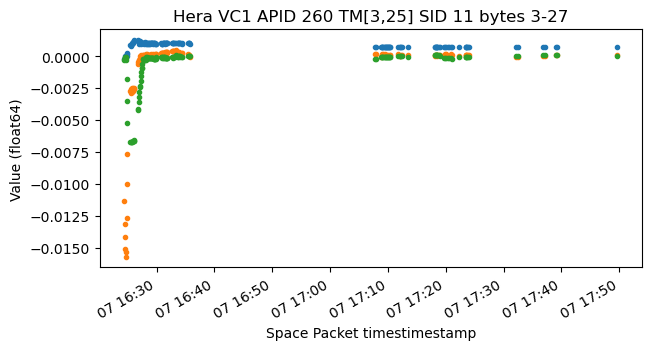

In [65]:
plot_tlm(11, slice(3, 3+3*8))

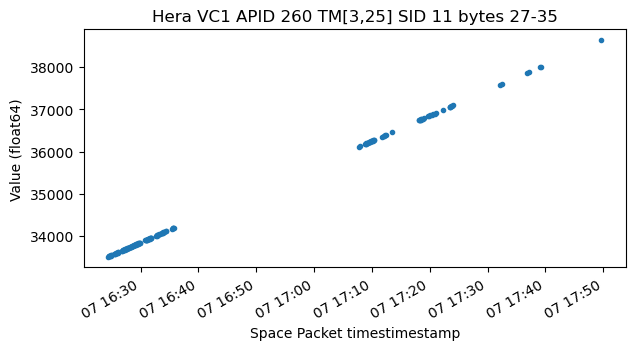

In [66]:
plot_tlm(11, slice(3+3*8, 3+4*8))

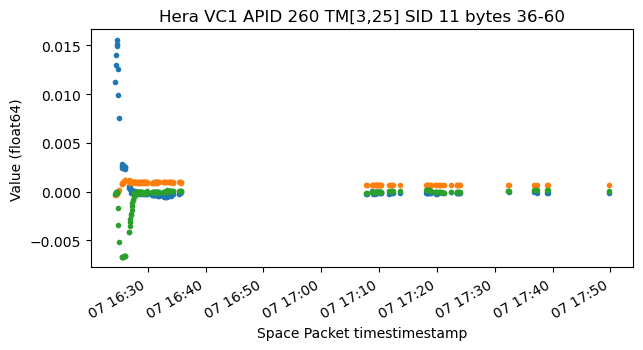

In [67]:
plot_tlm(11, slice(3+4*8+1, 3+4*8+1+3*8))

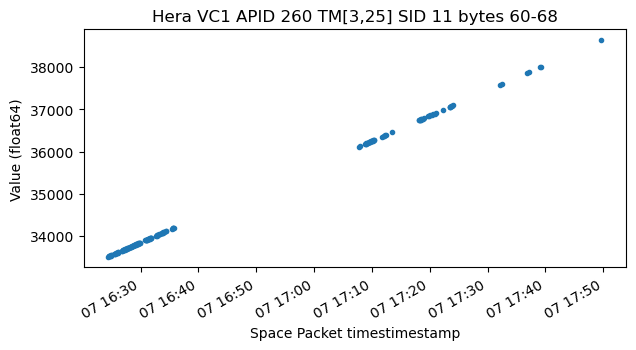

In [68]:
plot_tlm(11, slice(3+4*8+1+3*8, 3+4*8+1+3*8+8))

### SID 14

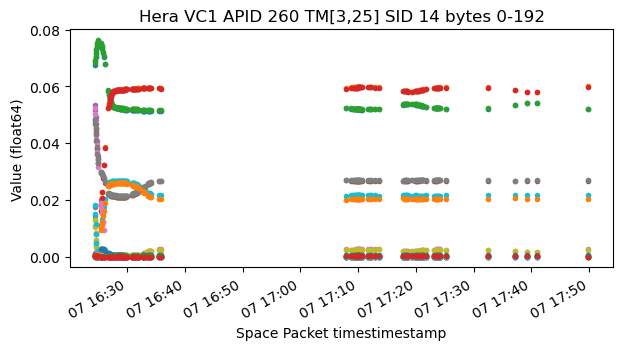

In [69]:
plot_tlm(14, slice(0, None))

### SID 21

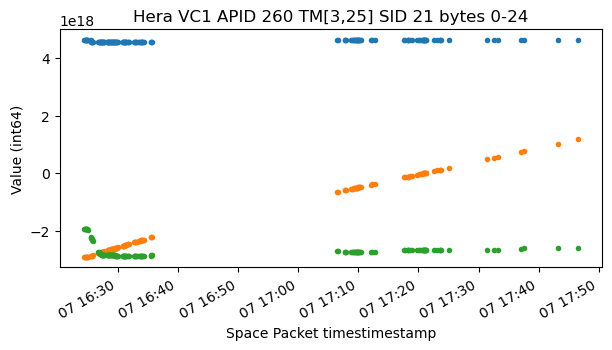

In [70]:
plot_tlm(21, slice(0, 3*8), fmt='int64')

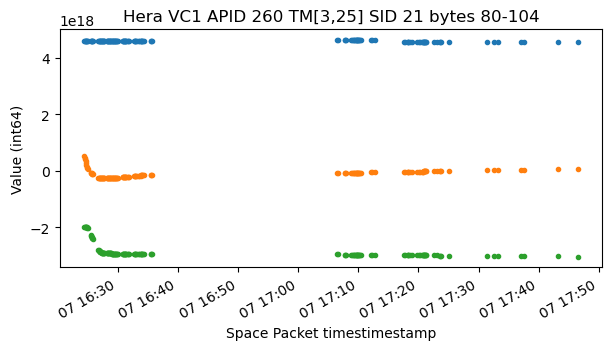

In [71]:
plot_tlm(21, slice(80, 80+3*8), fmt='int64')

### SID 50

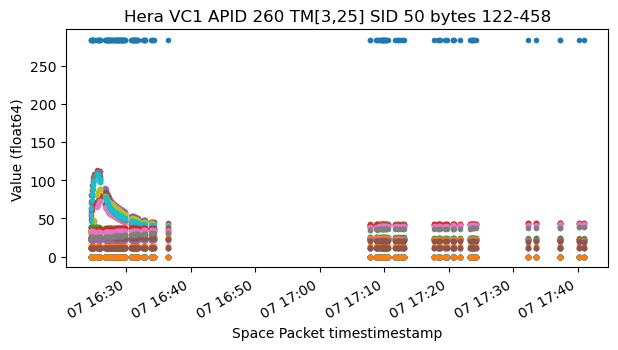

In [72]:
plot_tlm(50, slice(122, 122+42*8))

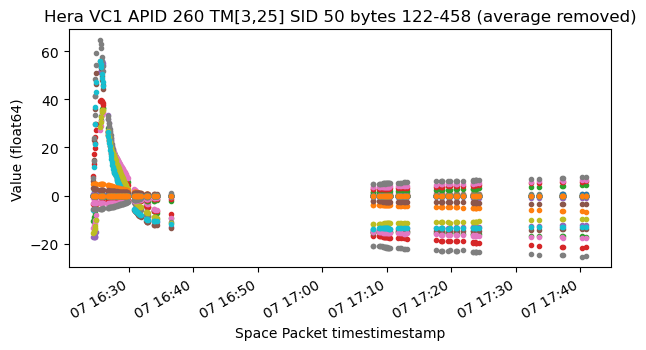

In [73]:
plot_tlm(50, slice(122, 122+42*8), minus_avg=True)

### SID 61

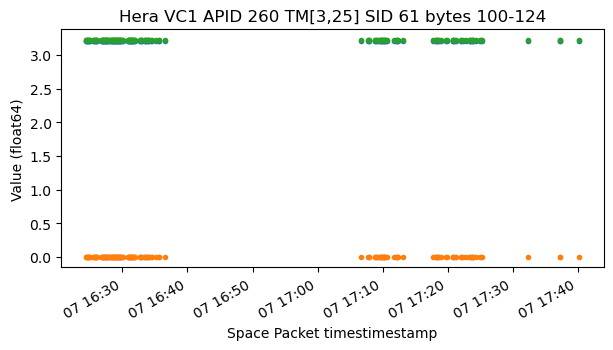

In [74]:
plot_tlm(61, slice(100, None))

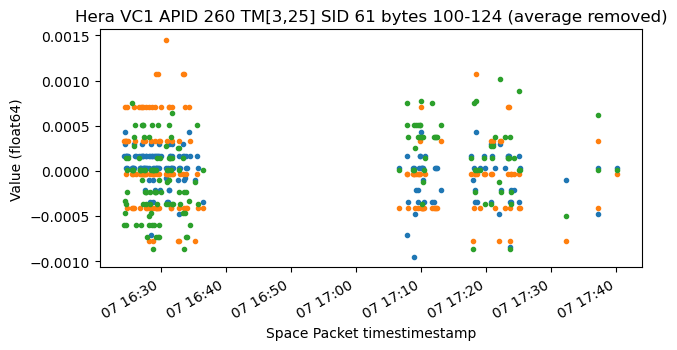

In [75]:
plot_tlm(61, slice(100, None), minus_avg=True)

### SID 62

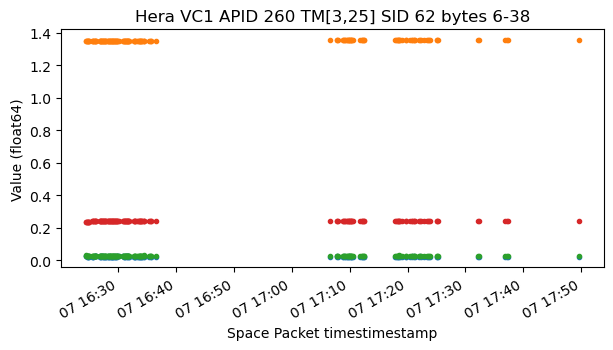

In [76]:
plot_tlm(62, slice(6, 6+4*8))

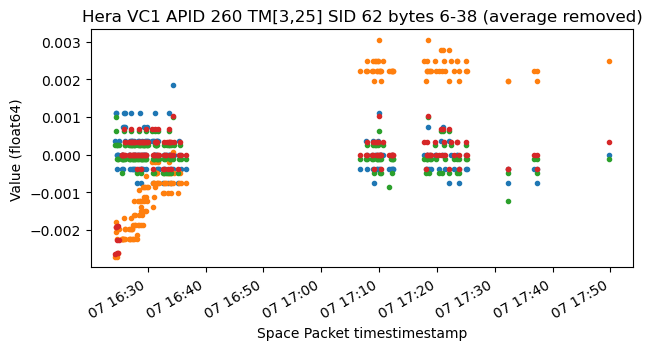

In [77]:
plot_tlm(62, slice(6, 6+4*8), minus_avg=True)

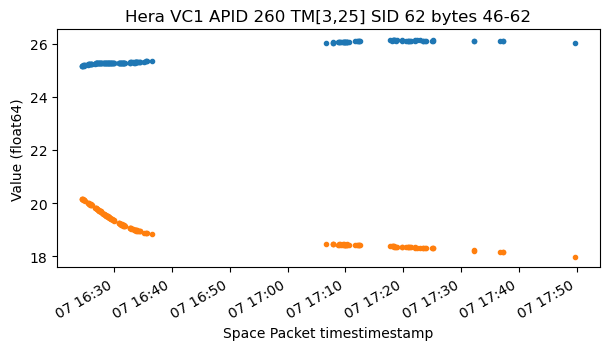

In [78]:
plot_tlm(62, slice(46, 46+2*8))

### SID 80

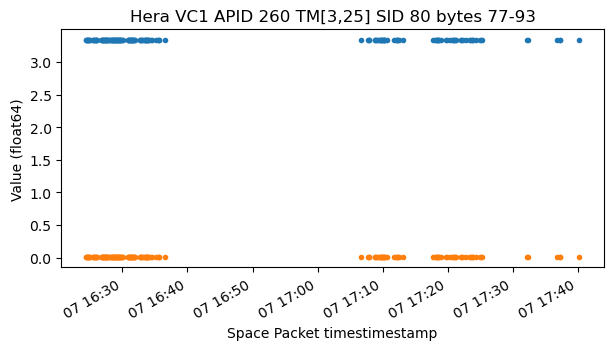

In [79]:
plot_tlm(80, slice(77, 77+2*8))

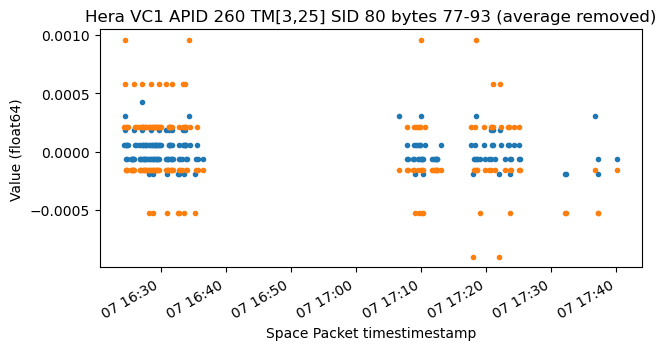

In [80]:
plot_tlm(80, slice(77, 77+2*8), minus_avg=True)

### SID 110

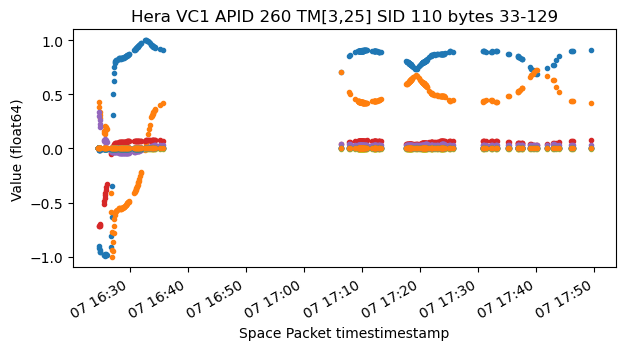

In [81]:
plot_tlm(110, slice(33, 33+12*8))

In [82]:
sid110_f64 = vc1_tm_3_25[110][:, 33:33+12*8].view('>f8')
np.sum(sid110_f64[:, :2]**2, axis=1)

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

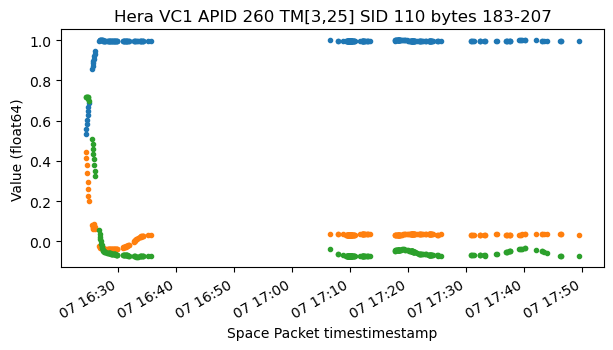

In [83]:
plot_tlm(110, slice(183, 183+3*8))

### SID 111

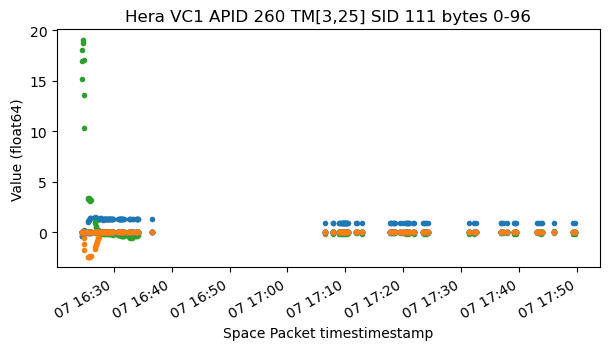

In [84]:
plot_tlm(111, slice(0, 12*8))

### SID 112

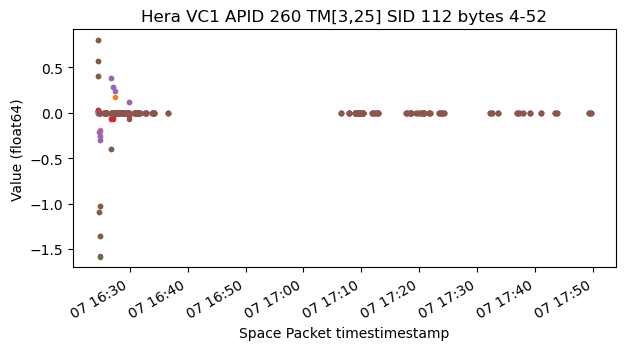

In [85]:
plot_tlm(112, slice(4, 4+6*8))

## APID 263

In [86]:
vc1_services_by_apid[263]
# (5, 1) is informative event report (event report service)
# (5, 2) is low severity anomaly report (event report service)
# (5, 3) is medium severity anomaly report (event report service)

Counter({(5, 1): 15, (5, 3): 3, (5, 2): 2})

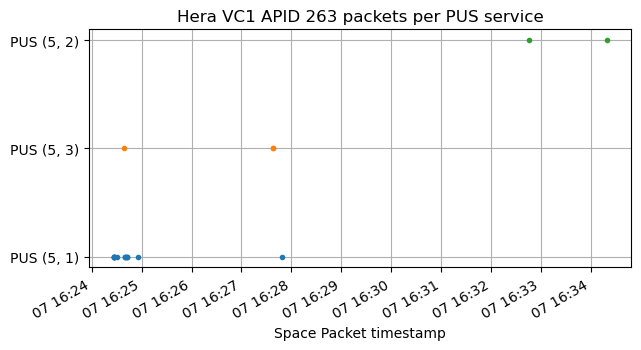

In [87]:
plot_pus_service_vc1(263)
plt.gcf().autofmt_xdate()

In [88]:
vc1_pus_by_apid[263]

[Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=852, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=853, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=854, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=855, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=856, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=857, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=858, dest

In [89]:
[a[source_data_offset:-2].hex() for a in vc1_by_apid[263]]

['010503bd19a6000000000000000010000000000000000100000000000000000200000082e80a0ea5',
 '010503be19a6000000000000000004000000000000000100000000000000000200000082e80a1016',
 '010503bf19a6000000000000000002000000000000000100000000000000000200000082e80a1155',
 '010503c019a6000000000000000001000000000000000100000000000000010200000082e80a1294',
 '010503e119b7000000000000000300000000000000814b00000000000001000200000082e80a1b2a',
 '01f9000000cd',
 '01fa000000cd',
 '02d7',
 '02cf0203',
 '03e8002d12ef0000000000000000ff000000000000000300000000000000020003000082fb0948dc',
 '03e8003a12ef01ffffffffffffffff000000000000000300000000000000020004000082fb0969a0',
 '0105019f130c0000000000000000ff000000000000000000000000000000000200000082fb09fc3b',
 '010501a0130d0000000000000000ff000000000000000000000000000000000200000082fb09fd9b',
 '010501a1130e0000000000000000ff000000000000000000000000000000000200000082fb09feda',
 '010502e92ddf01ffffffffffffffff000000000000000200000000000000000200000082fb0a5321',
 '02d8',


## APID 264

In [90]:
vc1_services_by_apid[264]
# (3, 26) is diagnostic parameter report (housekeeping service)

Counter({(3, 26): 162})

In [91]:
diag_sid = np.array([np.frombuffer(a[source_data_offset:][:2], 'uint8') for a in vc1_by_apid[264]]).view('>u2').ravel()
diag_sids = collections.Counter([int(a) for a in diag_sid])
diag_sids

Counter({205: 162})

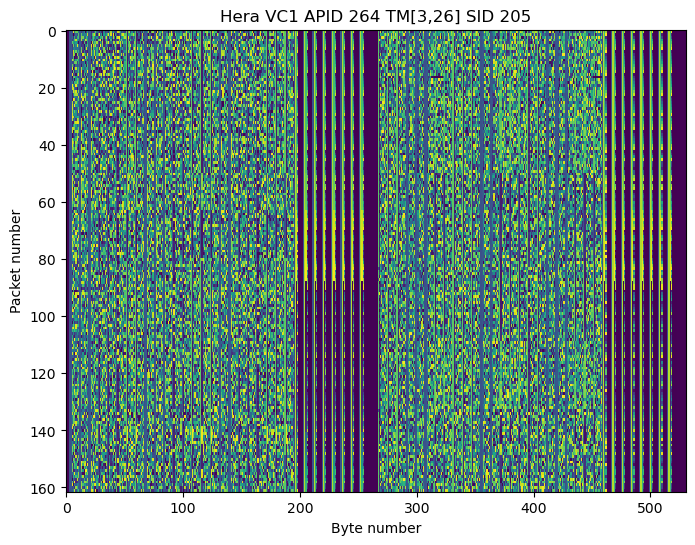

In [92]:
diagnostics = np.array([np.frombuffer(a[source_data_offset+2:-2], 'uint8') for a in vc1_by_apid[264]])
plt.figure(figsize=(8, 6))
plt.imshow(diagnostics, aspect='auto', interpolation='none')
plt.title(f'Hera VC1 APID 264 TM[3,26] SID 205')
plt.xlabel('Byte number')
plt.ylabel('Packet number');

In [93]:
diag_f64 = diagnostics[:, 3:].view('>f8')

In [94]:
def plot_diag(sel):
    plt.plot(vc1_t_by_apid[264], diag_f64[:, sel], '.')
    byterange = np.arange(diag_f64.shape[1])[sel]*8 + 3
    plt.title(f'Hera VC1 APID 264 TM[3,26] SID 205 bytes {byterange[0]}-{byterange[-1]+8}')
    plt.xlabel('Space Packet timestamp')
    plt.ylabel('Value (float64)')
    plt.gcf().autofmt_xdate()

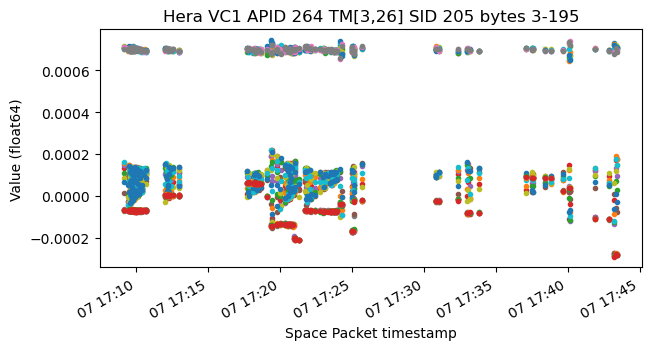

In [95]:
plot_diag(slice(0, 24))

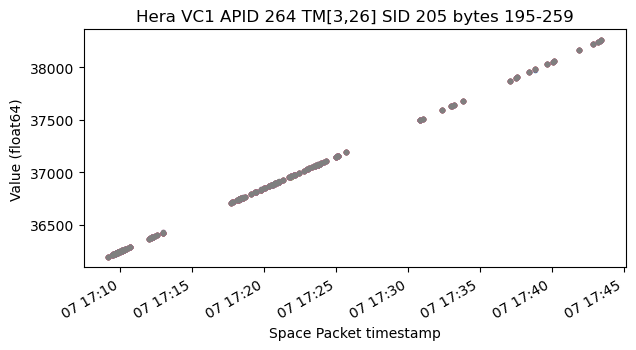

In [96]:
plot_diag(slice(24, 32))

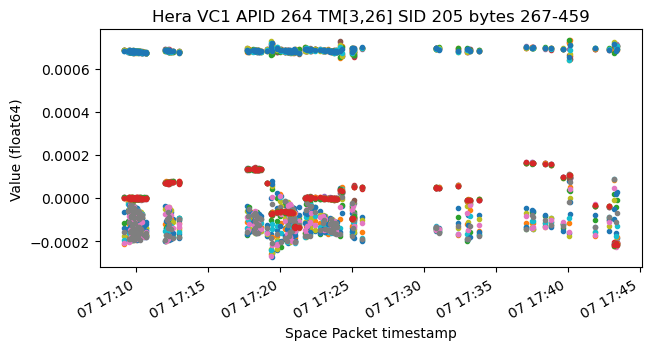

In [97]:
plot_diag(slice(33, 57))

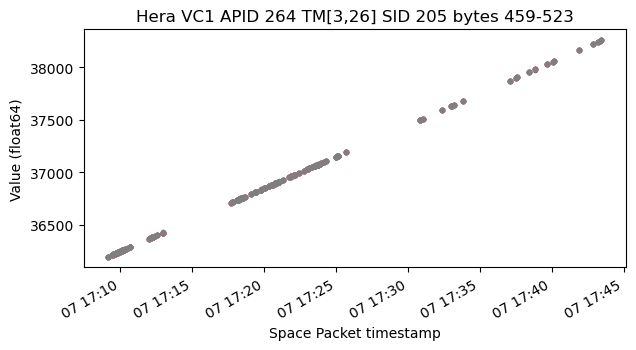

In [98]:
plot_diag(slice(57, 65))

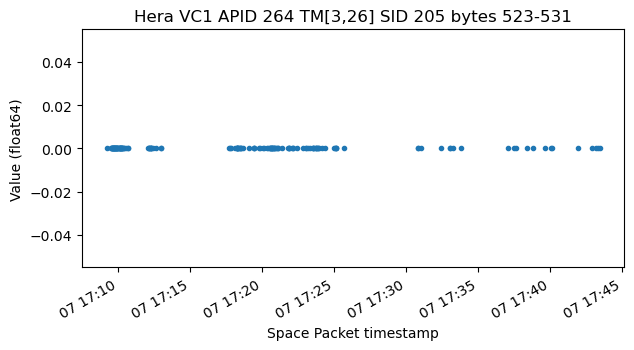

In [99]:
plot_diag(slice(65, None))

## APID 267

In [100]:
vc1_services_by_apid[267]
# (1, 1) is successful acceptance verification report (request verification service)
# (1, 7) is successful completion of execution verification report (request verification service)
# (20, 130) is ??? (on-board parameter management service)

Counter({(1, 1): 3, (20, 130): 3, (1, 7): 3})

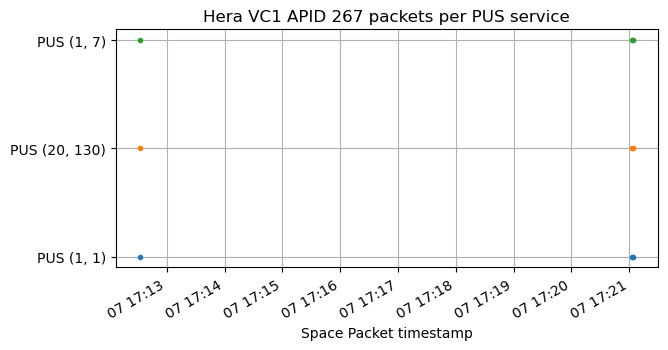

In [101]:
plot_pus_service_vc1(267)
plt.gcf().autofmt_xdate()

In [102]:
vc1_pus_by_apid[267]

[Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=39, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=20, message_subtype=130, message_type_counter=6, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=39, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=41, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=20, message_subtype=130, message_type_counter=8, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=41, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=42, destina

In [103]:
vc1_t_by_apid[267]

array(['2024-10-07T17:12:32.335535678', '2024-10-07T17:12:32.336191806',
       '2024-10-07T17:12:32.336771640', '2024-10-07T17:21:03.333002719',
       '2024-10-07T17:21:03.333658847', '2024-10-07T17:21:03.334223422',
       '2024-10-07T17:21:04.333124790', '2024-10-07T17:21:04.333902988',
       '2024-10-07T17:21:04.334696445'], dtype='datetime64[ns]')

In [104]:
service1_payloads_apid267 = [
    ccsds.SpacePacketPrimaryHeader.parse(
        a[source_data_offset:][:ccsds.SpacePacketPrimaryHeader.sizeof() - 2]
        + b'\x00\x00')
    for a, p in zip(vc1_by_apid[267], vc1_pus_by_apid[267]) if p.service_type == 1]
service1_payloads_apid267

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=267, sequence_flags=3, packet_sequence_count_or_name=12358, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=267, sequence_flags=3, packet_sequence_count_or_name=12358, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=267, sequence_flags=3, packet_sequence_count_or_name=12360, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=267, sequence_flags=3, packet_sequence_count_or_name=12360, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=267, sequence_flags=3, packet_sequence_count_or_name=12361, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=267, sequence_flags=3, packet_sequence_count_or_name=12361, data_length=0)]

In [105]:
tm_20_130 = [a for a, p in zip(vc1_by_apid[267], vc1_pus_by_apid[267]) if pus_service(p) == (20, 130)]
[a[source_data_offset:-2].hex() for a in tm_20_130]

['0041002f0001000100300001000003e800340001000100350001000100380001000a00390001000a003c00010000003c004900010001004e0001da675140004f00010288005000040000000000000000000000000000000000510001000000000052000300000000000000000000000000530001000000000054000300000000000000550001003c005600014068d9999999999a00570001407373333333333300580001402ab851eb851eb800590001402c47ae147ae148005a00014021cccccccccccd005b0001402c333333333333005c00014007333333333333005d0001400ccccccccccccd005e00014021cccccccccccd005f0001402c33333333333300600001400733333333333300610001400ccccccccccccd0062000100000096006300013fb999999999999a006400013fb999999999999a006500010000271000660001000027100067000100004e20006800014014000000000000006900014014000000000000006b000104fd006d000100000e10006f000100010073000100010074000c010507010100000d00b93f010075000c090004000000000a00b93f010076000c090004000000000a00b93f01007700010000000a007800010000000600790001000000e6007a000100000001007b00010001007d000100007e000100007f000100008000010000810001000082

## APID 286

In [106]:
vc1_services_by_apid[286]
# (1, 1) is successful acceptance verification report (request verification service)

Counter({(1, 1): 2})

In [107]:
vc1_t_by_apid[286]

array(['2024-10-07T17:24:00.332850131', '2024-10-07T17:24:19.332194003'],
      dtype='datetime64[ns]')

In [108]:
service1_payloads_apid286 = [
    ccsds.SpacePacketPrimaryHeader.parse(
        a[source_data_offset:][:ccsds.SpacePacketPrimaryHeader.sizeof() - 2]
        + b'\x00\x00')
    for a in vc1_by_apid[286]]
service1_payloads_apid286

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=286, sequence_flags=3, packet_sequence_count_or_name=14690, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=286, sequence_flags=3, packet_sequence_count_or_name=14692, data_length=0)]

## APID 291

In [109]:
vc1_services_by_apid[291]
# (1, 1) is successful acceptance verification report (request verification service)

Counter({(1, 1): 1})

In [110]:
vc1_t_by_apid[291]

array(['2024-10-07T17:11:44.324595126'], dtype='datetime64[ns]')

In [111]:
service1_payloads_apid291 = [
    ccsds.SpacePacketPrimaryHeader.parse(
        a[source_data_offset:][:ccsds.SpacePacketPrimaryHeader.sizeof() - 2]
        + b'\x00\x00')
    for a in vc1_by_apid[291]]
service1_payloads_apid291

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=291, sequence_flags=3, packet_sequence_count_or_name=10537, data_length=0)]

# VC3

In [112]:
vc3_packets = list(ccsds.extract_space_packets(tm, 0xb5, 3))
vc3_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc3_packets]

/home/daniel/contracting/HERA/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 181 VC 3] Broken stream. Last frame count 238, current frame count 245
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/HERA/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 181 VC 3] Broken stream. Last frame count 245, current frame count 249
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/HERA/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 181 VC 3] Broken stream. Last frame count 250, current frame count 252
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/hom

In [113]:
vc3_headers[:5]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=2350, data_length=113),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=2351, data_length=113),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=2352, data_length=113),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=2353, data_length=179),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=260, sequence_flags=3, packet_sequence_count_or_name=2354, data_length=189)]

In [114]:
vc3_apids = collections.Counter([p.APID for p in vc3_headers])
vc3_apids

Counter({260: 7069, 263: 89, 257: 52, 261: 2})

In [115]:
vc3_by_apid = {apid: [p for p, h in zip(vc3_packets, vc3_headers) if h.APID == apid]
               for apid in vc3_apids}
vc3_t_by_apid = {apid: np.array([(to_timestamp_pus if apid != 0 else to_timestamp_time_packet)(p)
                                 for p in vc3_by_apid[apid]])
                 for apid in vc3_apids if apid not in [2047]}
vc3_pus_by_apid = {apid: [PUSHeader.parse(p[ccsds.SpacePacketPrimaryHeader.sizeof():])
                          for p in vc3_by_apid[apid]]
                   for apid in vc3_apids if apid not in [0, 2047]}
vc3_services_by_apid = {
    apid: collections.Counter([pus_service(p) for p in vc3_pus_by_apid[apid]])
    for apid in vc3_apids if apid not in [0, 2047]}

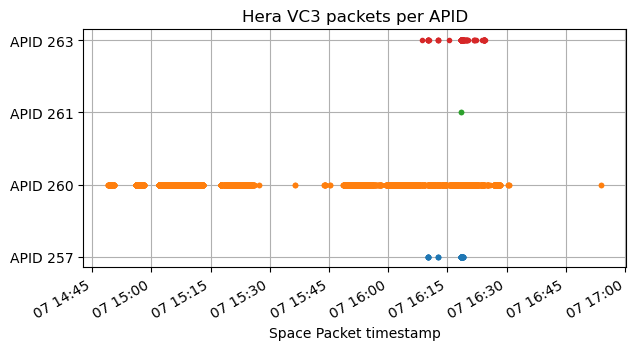

In [116]:
apid_list = sorted([a for a in vc3_apids if a not in [2047]])
for j, apid in enumerate(apid_list):
    plt.plot(vc3_t_by_apid[apid], np.ones(vc3_t_by_apid[apid].size) * j, '.'),
plt.yticks(np.arange(len(apid_list)), [f'APID {a}' for a in apid_list])
plt.grid()
plt.title('Hera VC3 packets per APID')
plt.xlabel('Space Packet timestamp')
plt.gcf().autofmt_xdate();

In [117]:
vc3_t_by_apid[260][0]

np.datetime64('2024-10-07T14:49:02.846354160')

In [118]:
def plot_pus_service_vc3(apid):
    for j, service in enumerate(vc3_services_by_apid[apid]):
        sel = [pus_service(p) == service for p in vc3_pus_by_apid[apid]]
        plt.plot(vc3_t_by_apid[apid][sel], np.ones(np.sum(sel)) * j, '.')
    plt.yticks(np.arange(len(vc3_services_by_apid[apid])), [f'PUS {a}' for a in vc3_services_by_apid[apid]])
    plt.grid()
    plt.title(f'HERA VC3 APID {apid} packets per PUS service')
    plt.xlabel('Space Packet timestamp')
    plt.gcf().autofmt_xdate();

## APID 257

In [119]:
vc3_services_by_apid[257]
# (1, 1) is successful acceptance verification report (request verification service)
# (1, 7) is successful completion of execution verification report (request verification service)
# (12, 12) is check transition report (on-board monitoring)

Counter({(12, 12): 46, (1, 1): 3, (1, 7): 3})

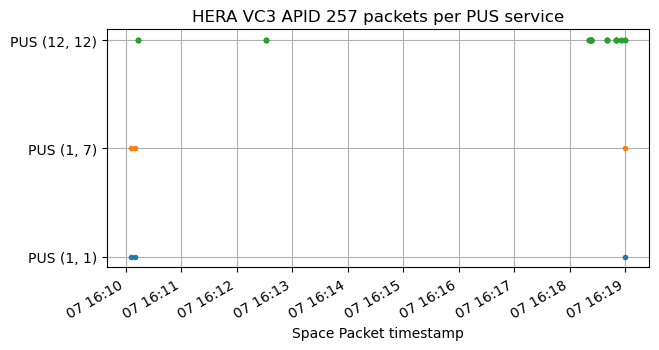

In [120]:
plot_pus_service_vc3(257)

In [121]:
vc3_pus_by_apid[257]

[Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=1, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=1, message_subtype=7, message_type_counter=0, destination_id=257),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=12, message_subtype=12, message_type_counter=229, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=12, message_subtype=12, message_type_counter=230, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=12, message_subtype=12, message_type_counter=231

In [122]:
vc3_t_by_apid[257]

array(['2024-10-07T16:10:06.325205478', '2024-10-07T16:10:06.325602207',
       '2024-10-07T16:10:10.325373325', '2024-10-07T16:10:10.325724277',
       '2024-10-07T16:10:13.317698154', '2024-10-07T16:10:13.318033847',
       '2024-10-07T16:10:13.318323764', '2024-10-07T16:10:13.318613681',
       '2024-10-07T16:12:31.318384799', '2024-10-07T16:12:31.318766269',
       '2024-10-07T16:12:31.319529208', '2024-10-07T16:12:31.319834384',
       '2024-10-07T16:18:21.319452915', '2024-10-07T16:18:21.319742832',
       '2024-10-07T16:18:21.320032749', '2024-10-07T16:18:21.320322666',
       '2024-10-07T16:18:22.317545566', '2024-10-07T16:18:23.315683994',
       '2024-10-07T16:18:23.316019687', '2024-10-07T16:18:23.316767368',
       '2024-10-07T16:18:23.317072543', '2024-10-07T16:18:23.318567905',
       '2024-10-07T16:18:23.318873081', '2024-10-07T16:18:23.319162998',
       '2024-10-07T16:18:23.319513950', '2024-10-07T16:18:23.319803867',
       '2024-10-07T16:18:23.320093784', '2024-10-07

In [123]:
service1_payloads_vc3_apid257 = [
    ccsds.SpacePacketPrimaryHeader.parse(
        a[source_data_offset:][:ccsds.SpacePacketPrimaryHeader.sizeof() - 2]
        + b'\x00\x00')
    for a, p in zip(vc3_by_apid[257], vc3_pus_by_apid[257]) if p.service_type == 1]
service1_payloads_vc3_apid257

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=1, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=1, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=3, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=3, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=2, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=257, sequence_flags=3, packet_sequence_count_or_name=2, data_length=0)]

In [124]:
tm_12_12 = [a for a, p in zip(vc3_by_apid[257], vc3_pus_by_apid[257]) if pus_service(p) == (12, 12)]
[a[source_data_offset:-2].hex() for a in tm_12_12]

['02e513280000000000000000ff00000000000000000000000000000000020000007f8e091b3f',
 '02e613270000000000000000ff00000000000000000000000000000000020000007f8e091cb0',
 '02e713260000000000000000ff00000000000000000000000000000000020000007f8e091dee',
 '02e813250000000000000000ff00000000000000000000000000000000020000007f8e091f1c',
 '0418334201ffffffffffffffff403601d3e0000000000000000000000002000000801d095619',
 '041e422501ffffffffffffffff4034930d3ccccccd000000000000000002000000801d0959e6',
 '045d331f01ffffffffffffffff3fcee7f1930294eb000000000000000002000000801d09785f',
 '045f331101ffffffffffffffff3ff4814d25eb87c4000000000000000002000000801d097a02',
 '01ec17450000000000000000ff0000000000000001000000000000000102000000817b0972bc',
 '01ed17460000000000000000ff0000000000000001000000000000000102000000817b0973fb',
 '01ee17470000000000000000ff0000000000000001000000000000000102000000817b097529',
 '01ef17700000000000000000ff0000000000000001000000000000000102000000817b097657',
 '02de13450000000000000000ff

In [125]:
tm_12_12_a = np.array([np.frombuffer(a[source_data_offset:-2], 'uint8') for a in tm_12_12])
transition_time = (
    sclk_t0
    + np.concatenate((np.zeros((tm_12_12_a.shape[0], 1), 'uint8'),
                      tm_12_12_a[:, -7:]), axis=1).view('>u8').ravel() / 2**24 * 1e9 * np.timedelta64(1, 'ns'))
transition_time

array(['2024-10-07T16:10:03.317411992', '2024-10-07T16:10:03.317433986',
       '2024-10-07T16:10:03.317452940', '2024-10-07T16:10:03.317470941',
       '2024-10-07T16:12:26.318309995', '2024-10-07T16:12:26.318367991',
       '2024-10-07T16:12:26.318832967', '2024-10-07T16:12:26.318857941',
       '2024-10-07T16:18:16.318746957', '2024-10-07T16:18:16.318765971',
       '2024-10-07T16:18:16.318783972', '2024-10-07T16:18:16.318801972',
       '2024-10-07T16:18:20.320330951', '2024-10-07T16:18:21.315892968',
       '2024-10-07T16:18:21.315913948', '2024-10-07T16:18:21.316371950',
       '2024-10-07T16:18:21.316390964', '2024-10-07T16:18:20.320026967',
       '2024-10-07T16:18:20.320049974', '2024-10-07T16:18:20.320068988',
       '2024-10-07T16:18:20.320132944', '2024-10-07T16:18:20.320151958',
       '2024-10-07T16:18:20.320171985', '2024-10-07T16:18:20.320190999',
       '2024-10-07T16:18:20.320210966', '2024-10-07T16:18:20.320229980',
       '2024-10-07T16:18:20.320249948', '2024-10-07

In [126]:
check_type = tm_12_12_a[:, 4]
current_pmon_checking_status = tm_12_12_a[:, -8]
previous_pmon_checking_status = tm_12_12_a[:, -9]
check_type, previous_pmon_checking_status, current_pmon_checking_status

(array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0], dtype=uint8),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 3, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
        0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2,
        2, 2], dtype=uint8))

In [127]:
parameter_value_limit_checking = tm_12_12_a[check_type == 1, 13:13+8].view('>f8').ravel()
parameter_value_limit_checking

array([2.20071392e+001, 2.05744207e+001, 2.41453358e-001, 1.28156771e+000,
       2.84953940e+001, 2.85074520e+001, 2.84953940e+001, 2.85074520e+001,
       2.99405816e+001, 2.95782831e+001, 2.93032010e+001, 2.60156317e+001,
       3.39712772e+001, 2.62737072e+001, 2.16036398e+001, 3.23225861e+001,
       3.58420353e+001, 2.81793156e+001, 0.00000000e+000, 6.91691904e-323,
       0.00000000e+000], dtype='>f8')

In [128]:
limit_crossed_limit_checking = tm_12_12_a[check_type == 1, 13+8:13+16].view('>f8').ravel()
limit_crossed_limit_checking

array([0.0e+000, 0.0e+000, 0.0e+000, 0.0e+000, 1.2e+001, 1.2e+001,
       2.7e+001, 2.7e+001, 0.0e+000, 0.0e+000, 0.0e+000, 0.0e+000,
       0.0e+000, 0.0e+000, 0.0e+000, 0.0e+000, 0.0e+000, 0.0e+000,
       0.0e+000, 0.0e+000, 4.9e-324], dtype='>f8')

## APID 260

In [129]:
vc3_services_by_apid[260]
# (3, 25) is housekeeping parameter report (housekeeping service)

Counter({(3, 25): 7069})

In [130]:
hk_sid_vc3 = np.array([np.frombuffer(a[source_data_offset:][:2], 'uint8') for a in vc3_by_apid[260]]).view('>u2').ravel()
sids_vc3 = collections.Counter([int(a) for a in hk_sid_vc3])
sids_vc3

Counter({81: 1152,
         12: 296,
         83: 293,
         11: 292,
         10: 288,
         62: 282,
         21: 280,
         80: 278,
         15: 276,
         14: 271,
         22: 270,
         61: 269,
         33: 268,
         31: 264,
         111: 264,
         40: 263,
         110: 262,
         13: 261,
         112: 254,
         32: 245,
         1: 233,
         50: 212,
         41: 71,
         2: 61,
         106: 52,
         105: 45,
         39: 27,
         35: 15,
         36: 15,
         37: 6,
         103: 2,
         104: 2})

/tmp/ipykernel_57106/1947920202.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


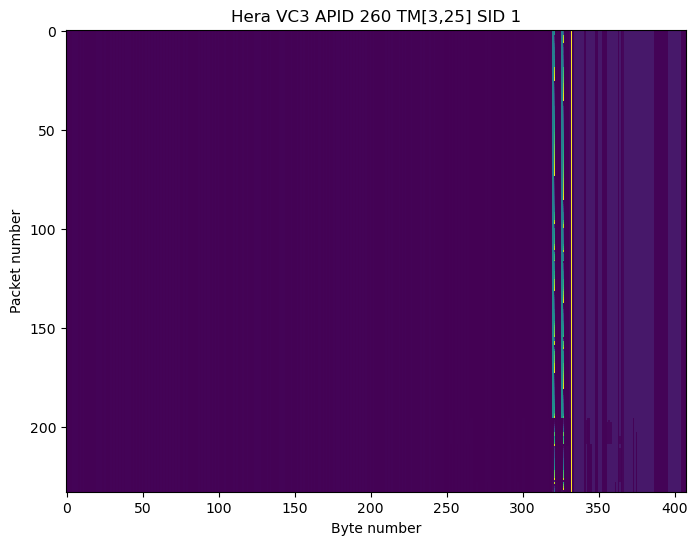

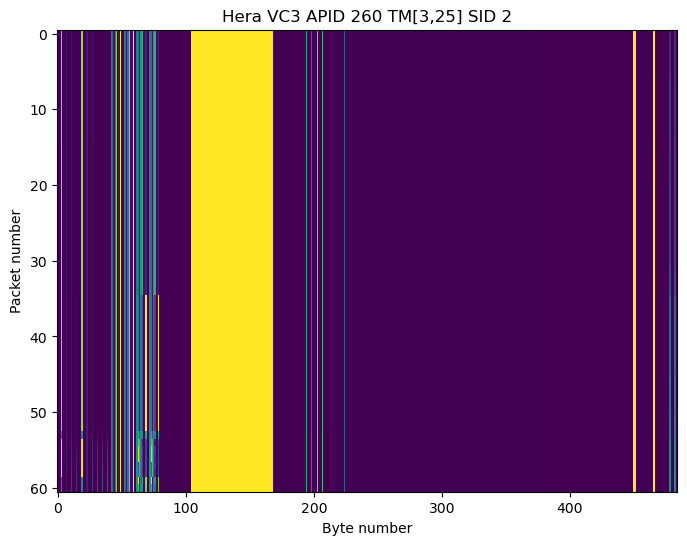

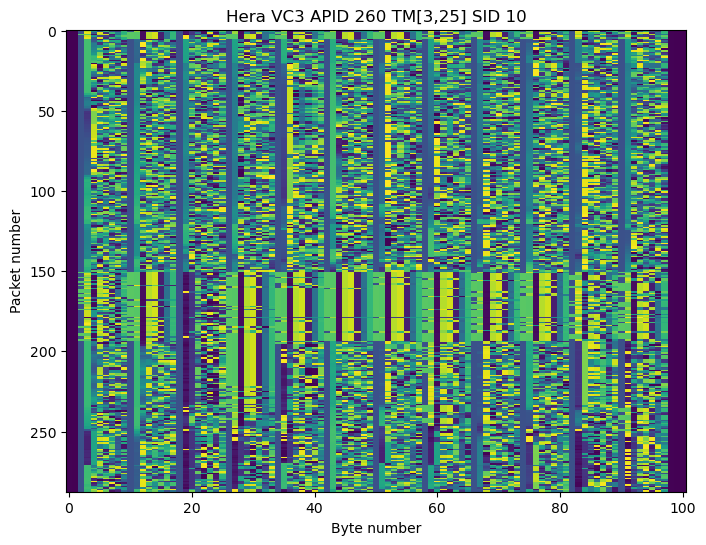

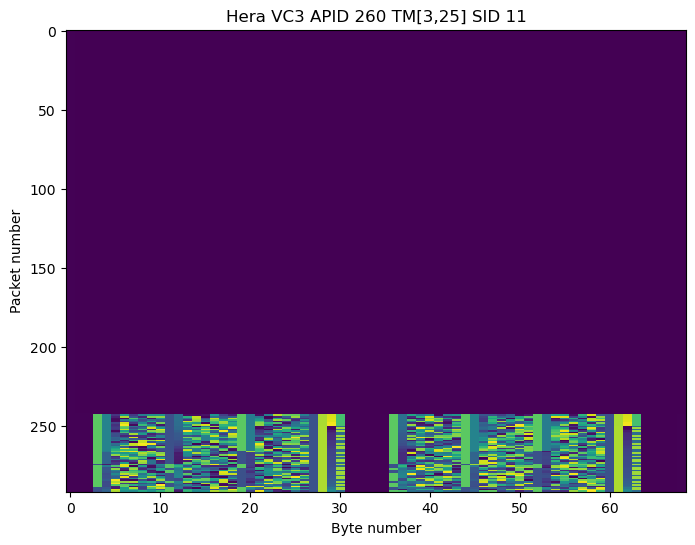

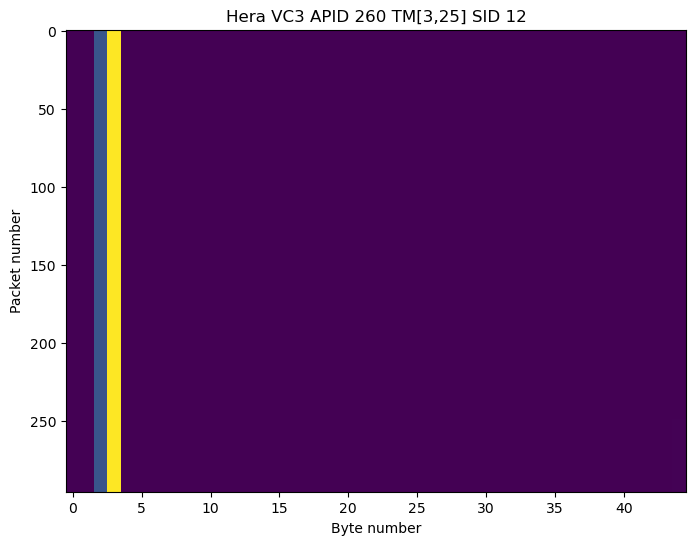

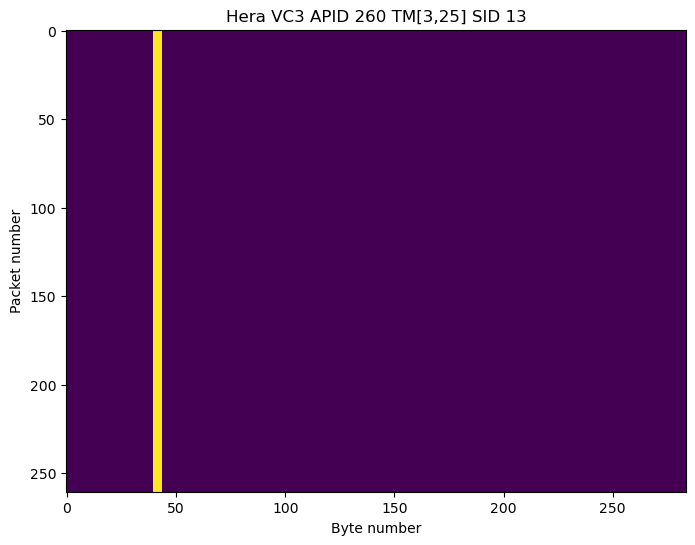

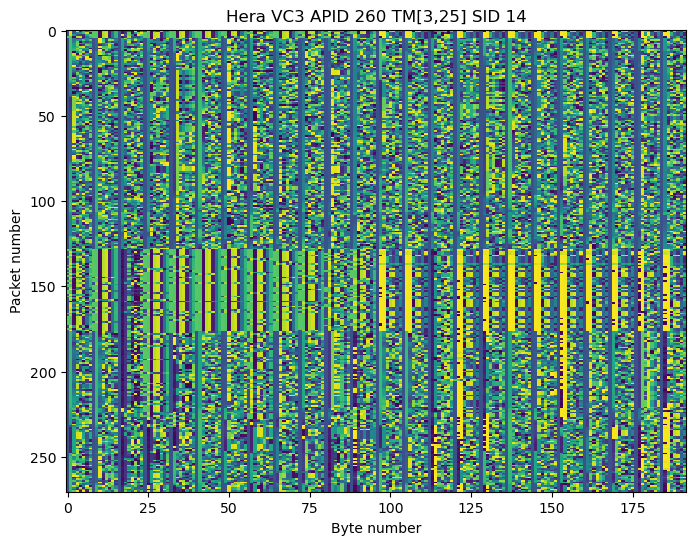

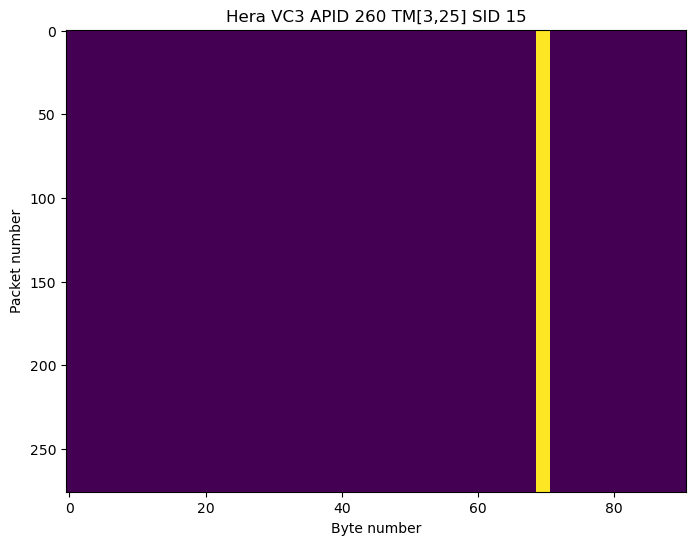

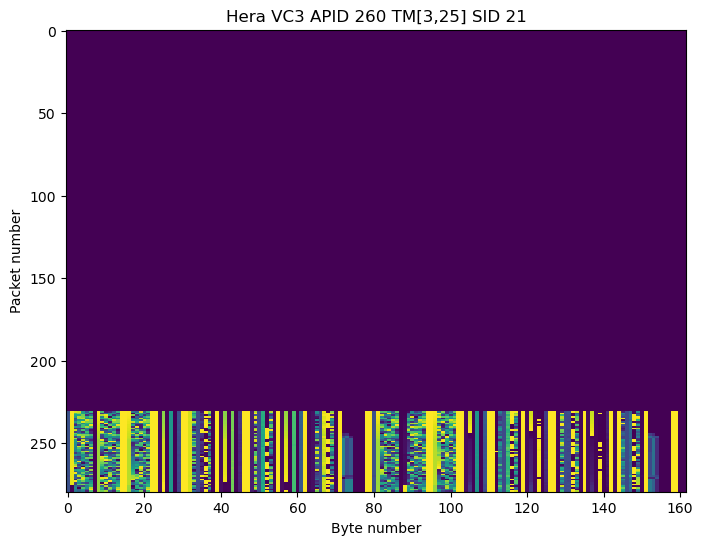

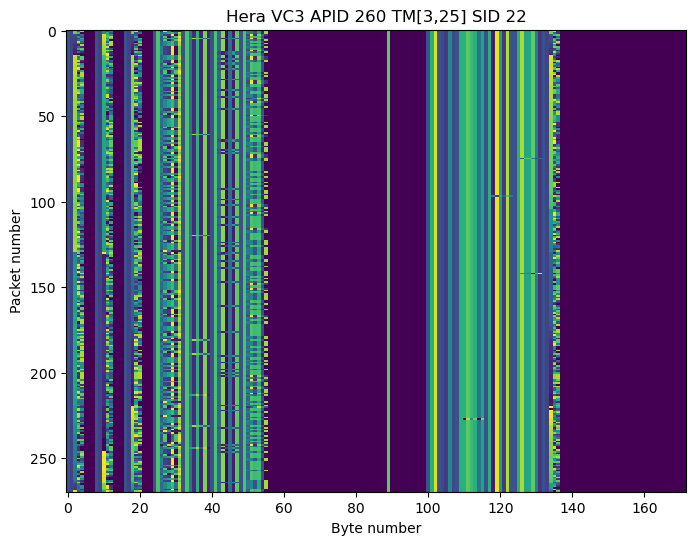

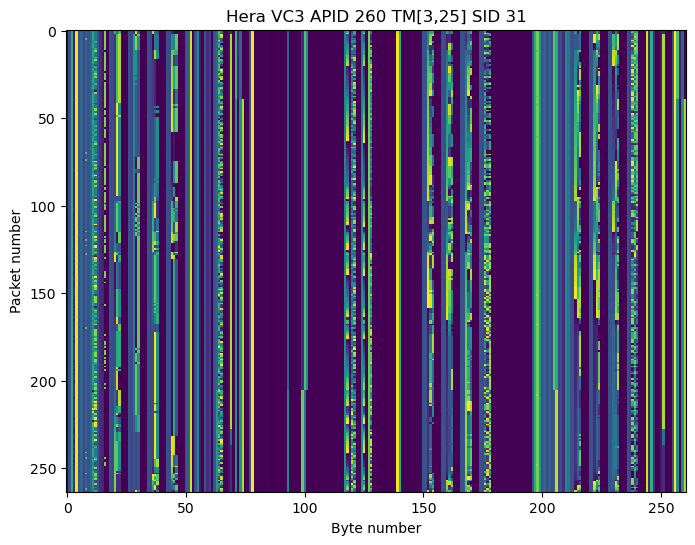

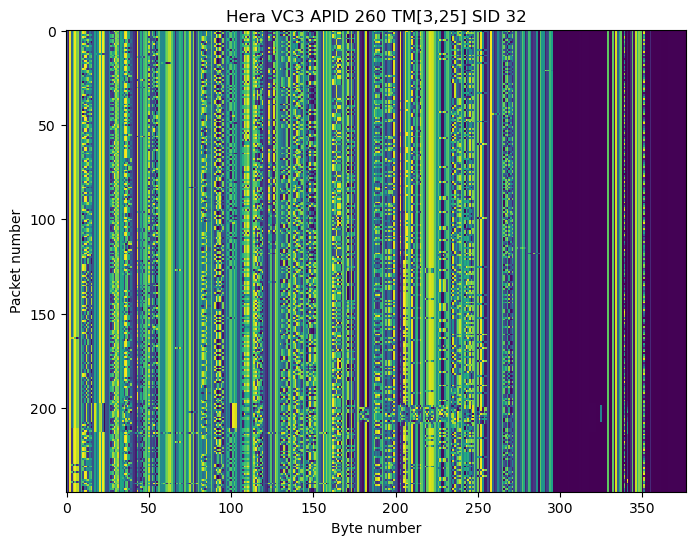

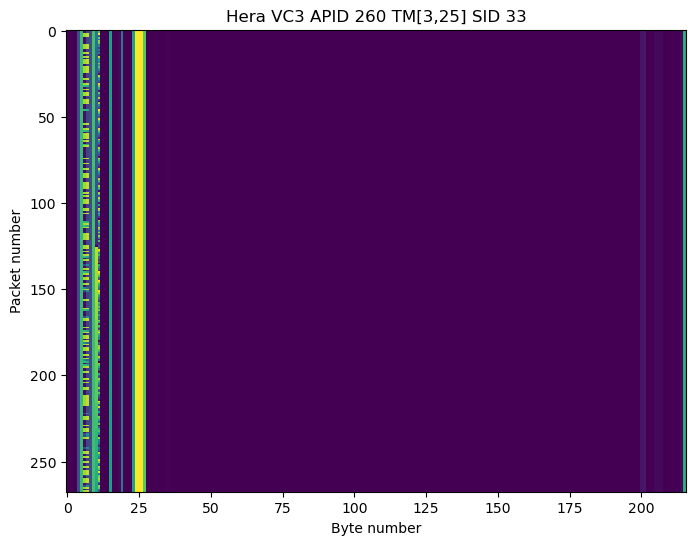

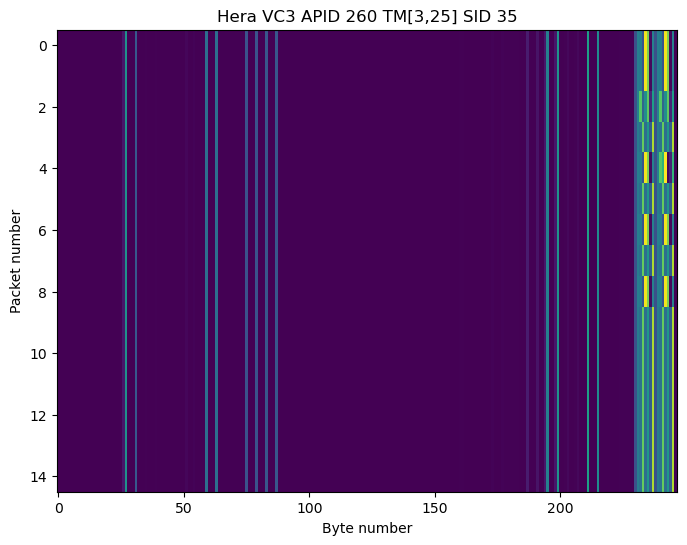

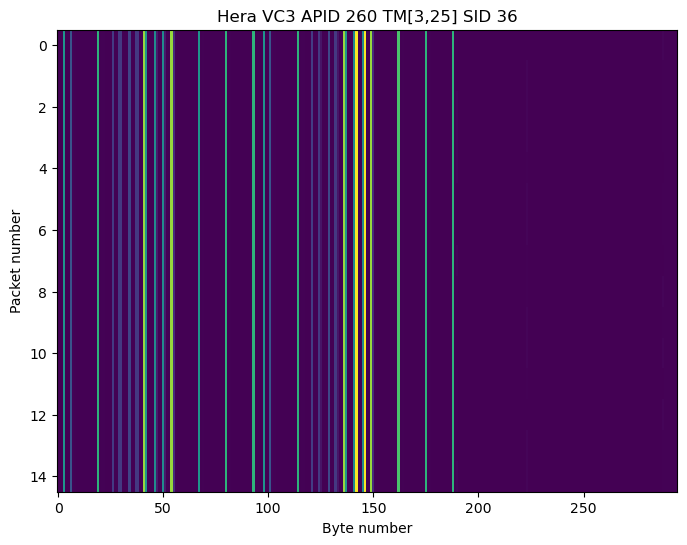

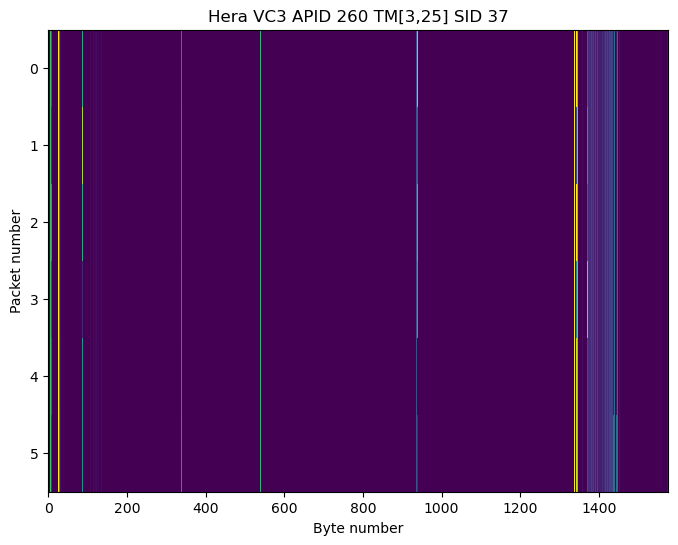

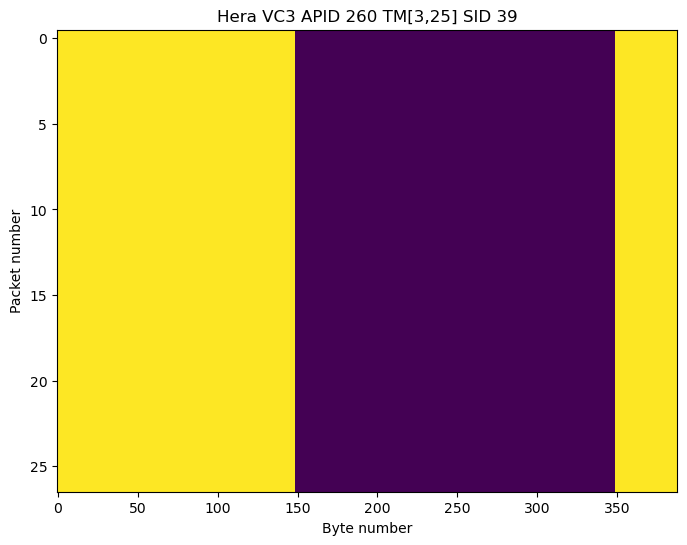

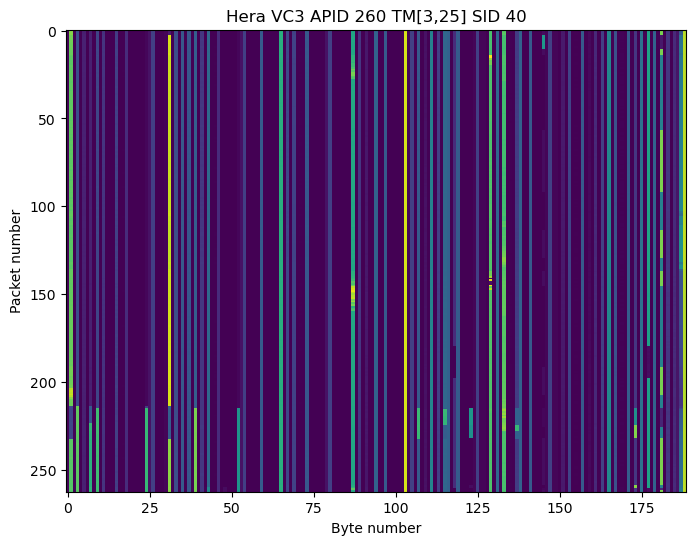

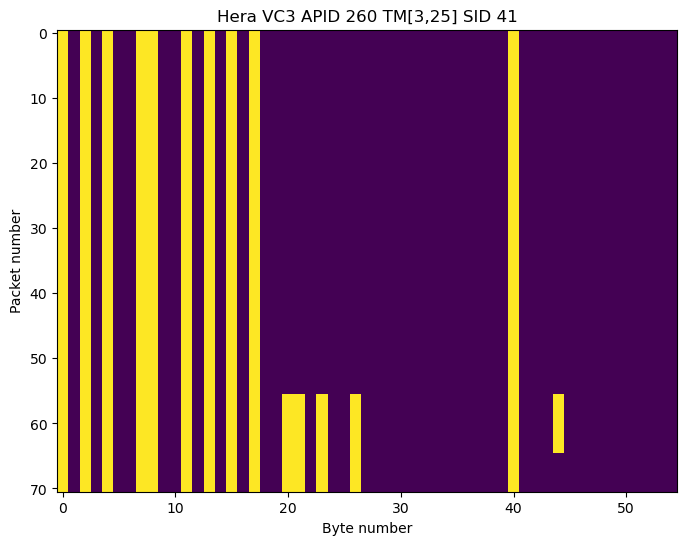

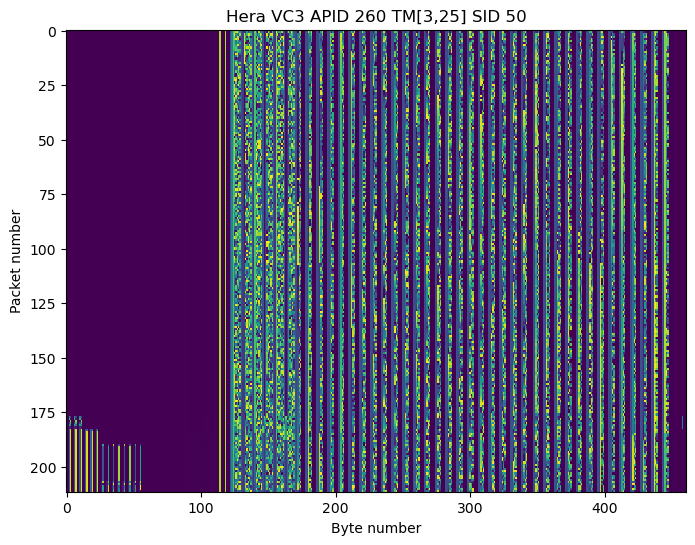

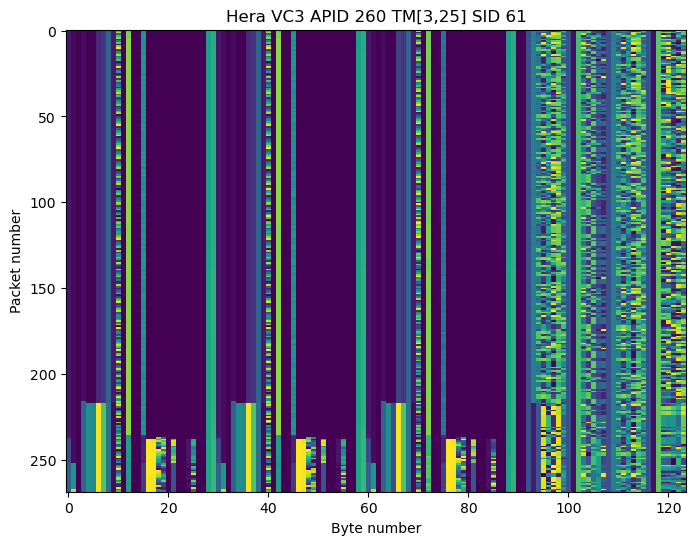

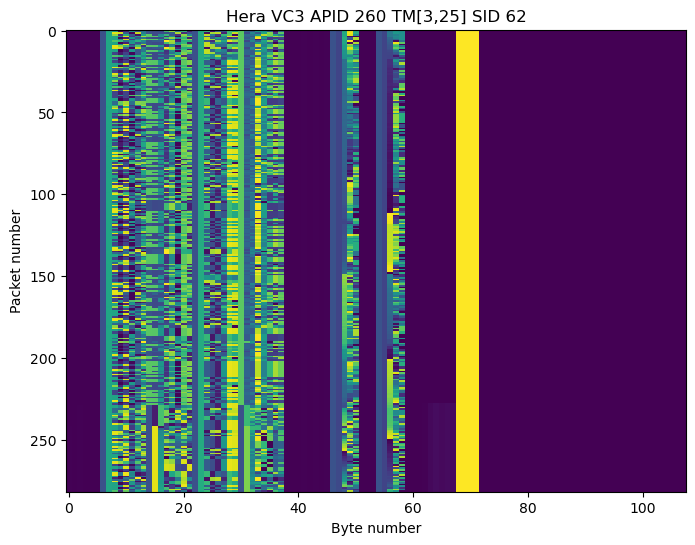

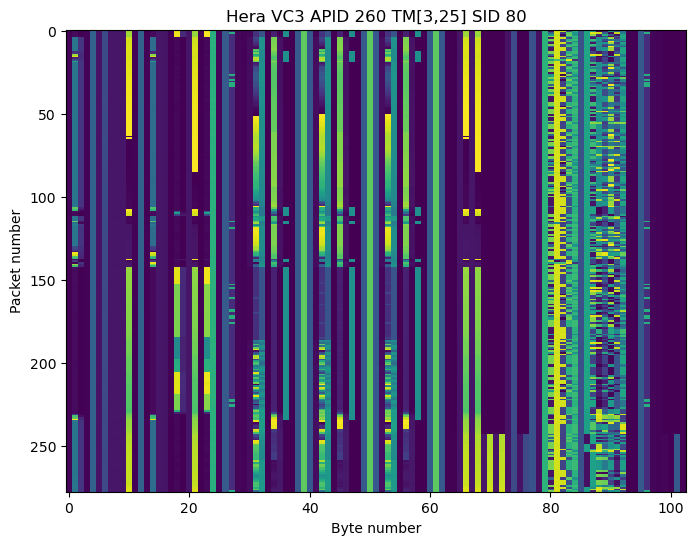

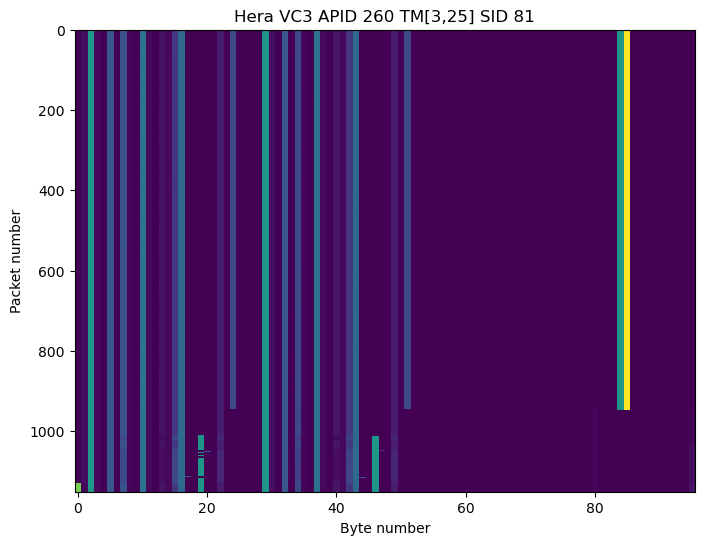

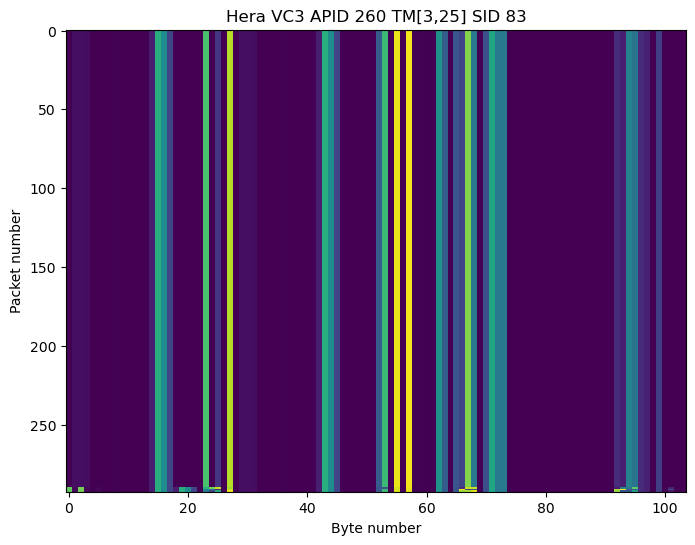

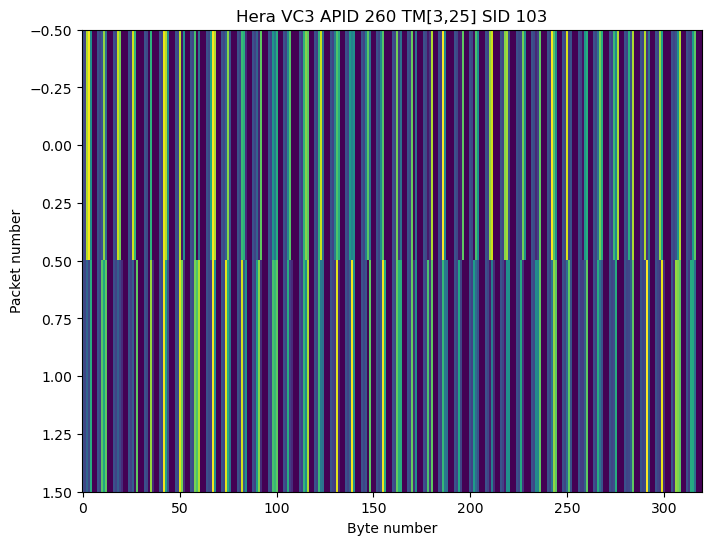

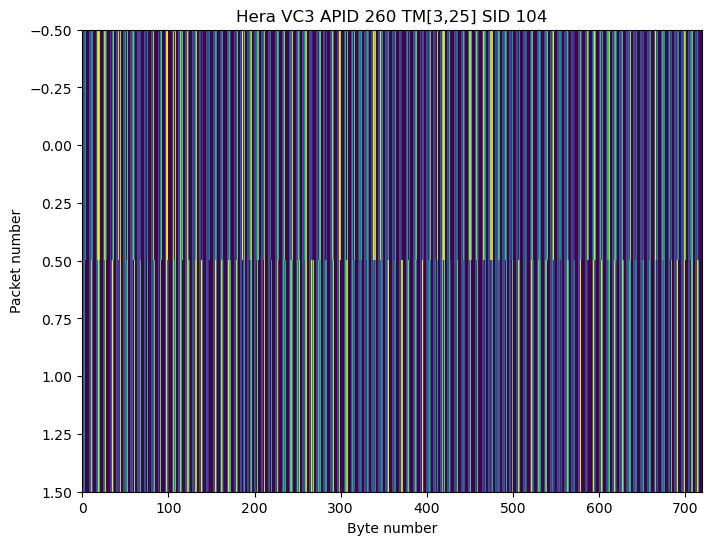

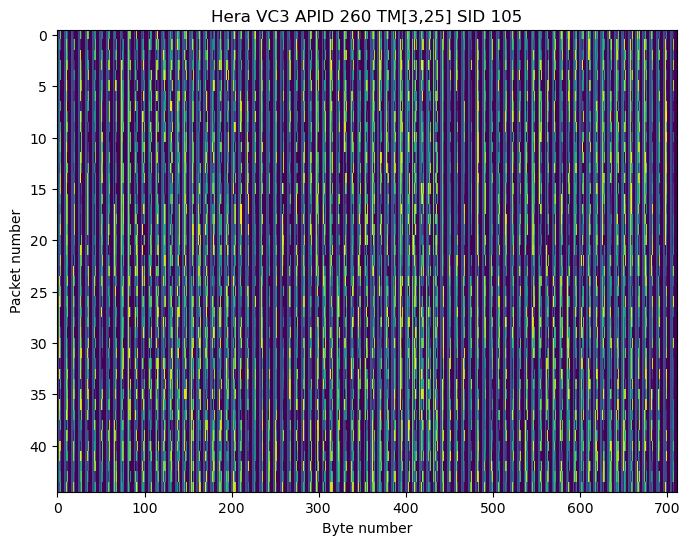

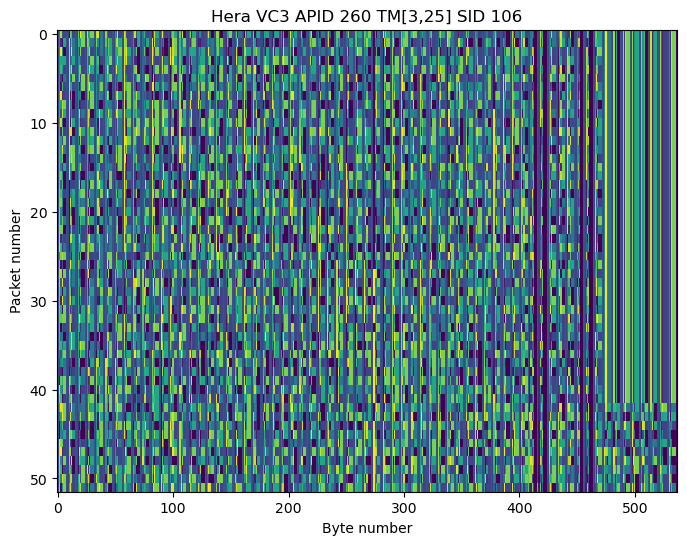

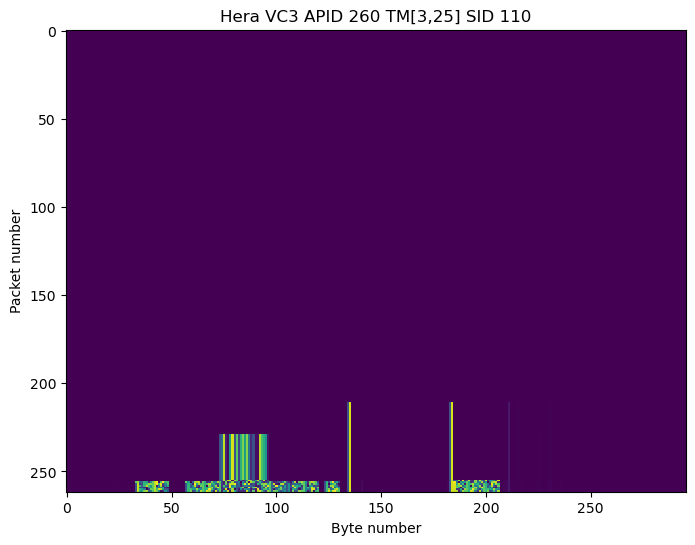

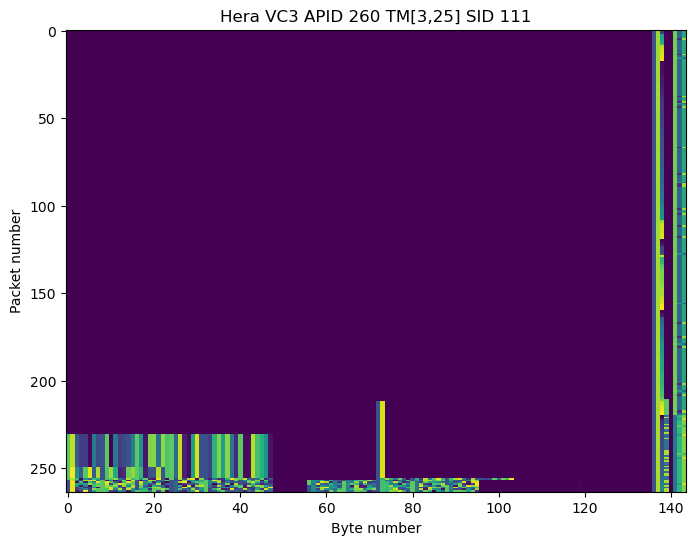

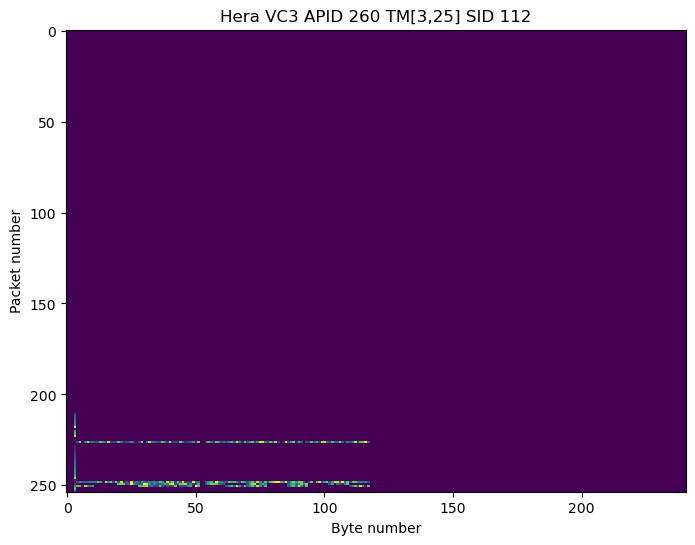

In [131]:
vc3_tm_3_25 = {}
vc3_tm_3_25_t = {}
for sid in sorted(sids):
    data = np.array([np.frombuffer(a[source_data_offset+2:-2], 'uint8') for a in vc3_by_apid[260]
                     if struct.unpack('>H', a[source_data_offset:][:2])[0] == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(data, aspect='auto', interpolation='none')
    plt.title(f'Hera VC3 APID 260 TM[3,25] SID {sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')
    vc3_tm_3_25[sid] = data
    vc3_tm_3_25_t[sid] = np.array([t for t, a in zip(vc3_t_by_apid[260], vc3_by_apid[260])
                                   if struct.unpack('>H', a[source_data_offset:][:2])[0] == sid])

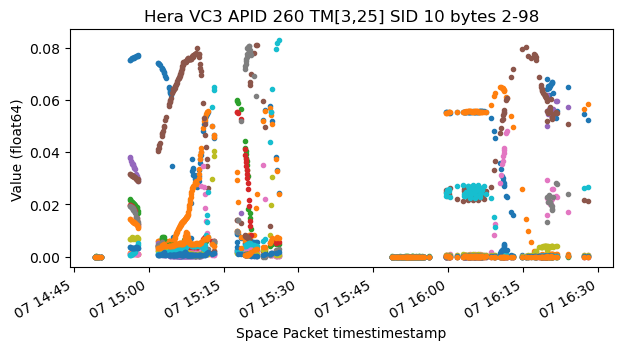

In [132]:
plot_tlm(10, slice(2, -3), vc=3)

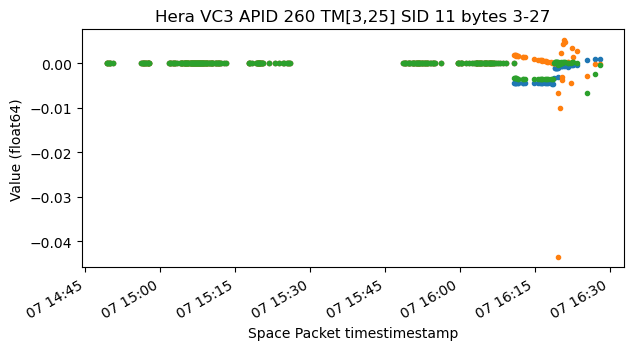

In [133]:
plot_tlm(11, slice(3, 3+3*8), vc=3)

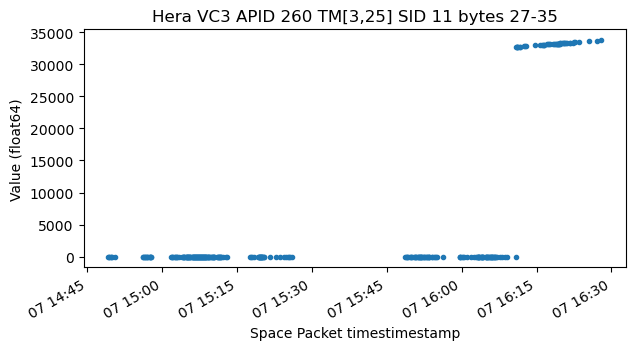

In [134]:
plot_tlm(11, slice(3+3*8, 3+4*8), vc=3)

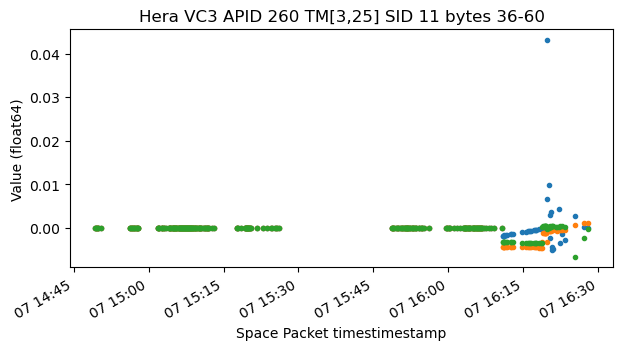

In [135]:
plot_tlm(11, slice(3+4*8+1, 3+4*8+1+3*8), vc=3)

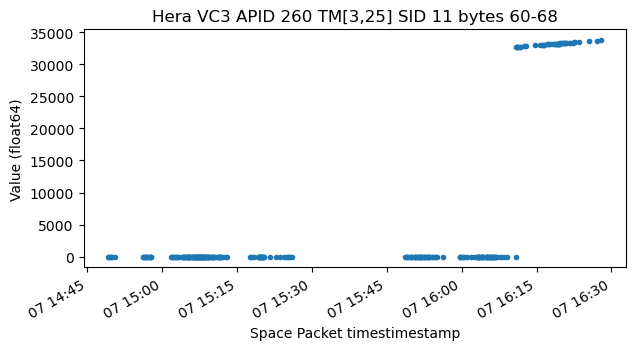

In [136]:
plot_tlm(11, slice(3+4*8+1+3*8, 3+4*8+1+3*8+8), vc=3)

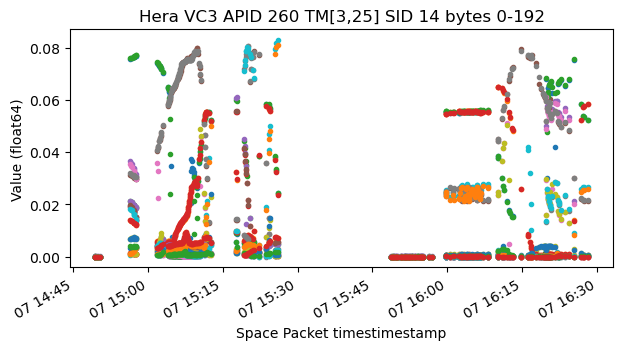

In [137]:
plot_tlm(14, slice(0, None), vc=3)

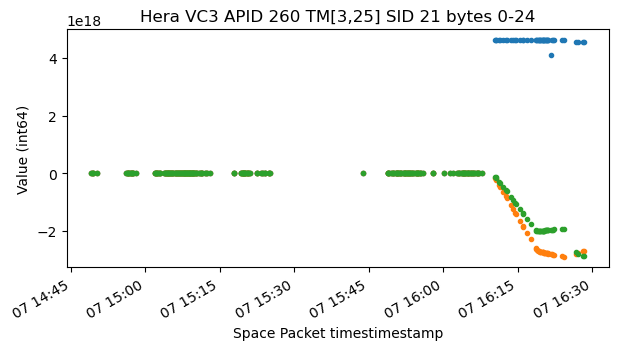

In [138]:
plot_tlm(21, slice(0, 3*8), fmt='int64', vc=3)

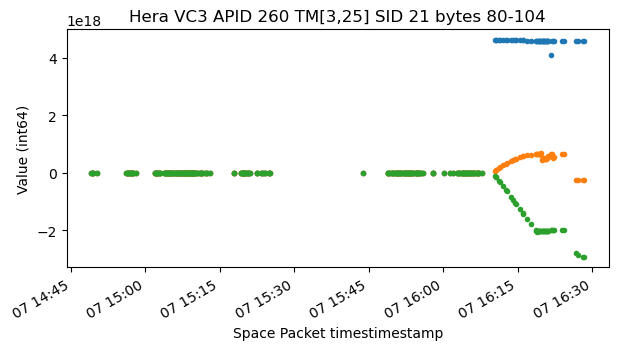

In [139]:
plot_tlm(21, slice(80, 80+3*8), fmt='int64', vc=3)

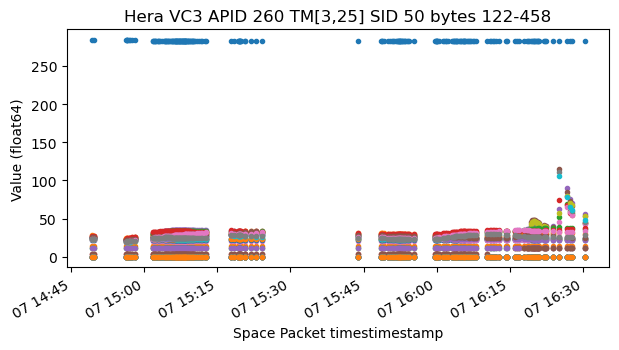

In [140]:
plot_tlm(50, slice(122, 122+42*8), vc=3)

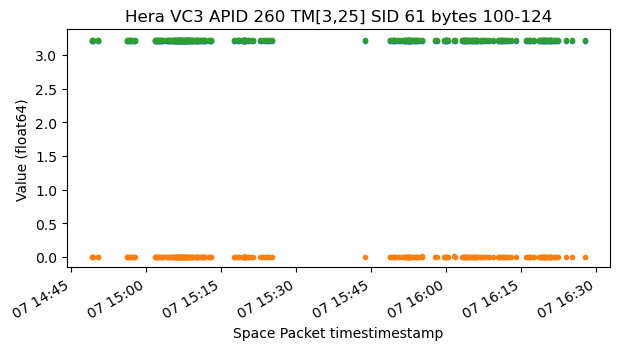

In [141]:
plot_tlm(61, slice(100, None), vc=3)

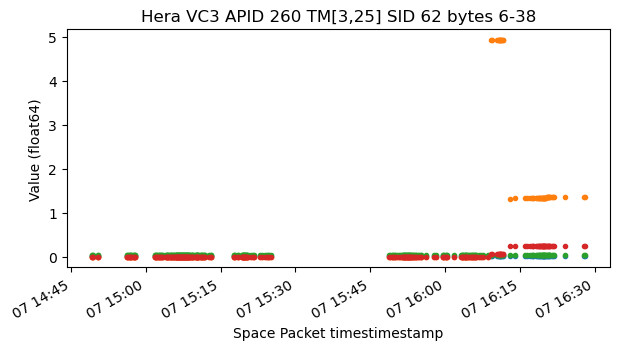

In [142]:
plot_tlm(62, slice(6, 6+4*8), vc=3)

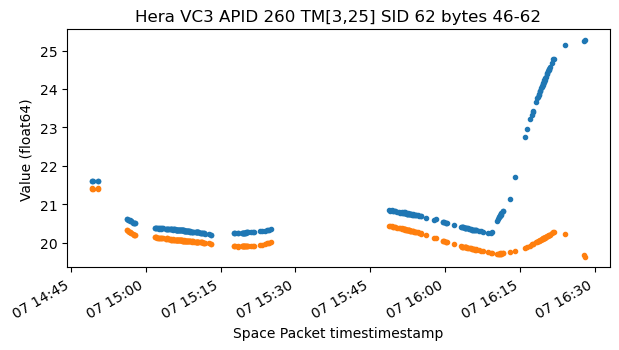

In [143]:
plot_tlm(62, slice(46, 46+2*8), vc=3)

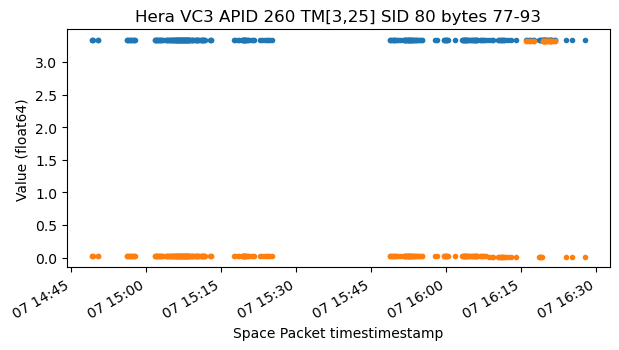

In [144]:
plot_tlm(80, slice(77, 77+2*8), vc=3)

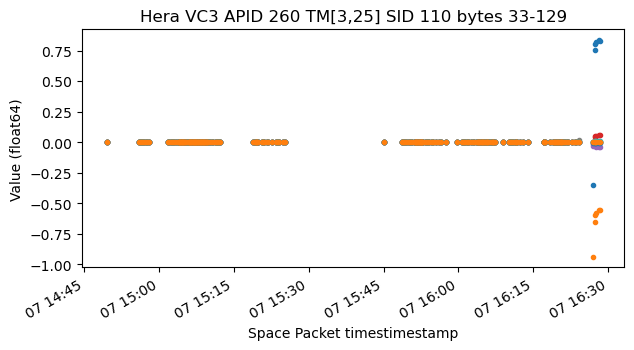

In [145]:
plot_tlm(110, slice(33, 33+12*8), vc=3)

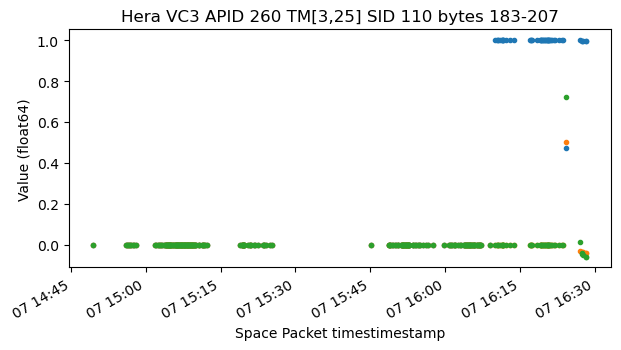

In [146]:
plot_tlm(110, slice(183, 183+3*8), vc=3)

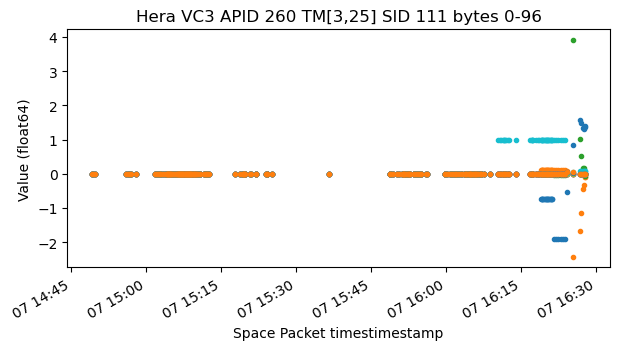

In [147]:
plot_tlm(111, slice(0, 12*8), vc=3)

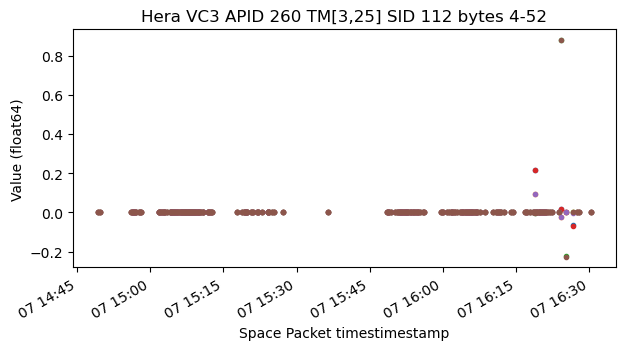

In [148]:
plot_tlm(112, slice(4, 4+6*8), vc=3)

## APID 261

In [149]:
vc3_services_by_apid[261]
# (1, 1) is successful acceptance verification report (request verification service)
# (1, 7) is successful completion of execution verification report (request verification service)

Counter({(1, 1): 1, (1, 7): 1})

In [150]:
vc3_t_by_apid[261]

array(['2024-10-07T16:18:20.328715000', '2024-10-07T16:18:20.329081210'],
      dtype='datetime64[ns]')

In [151]:
service1_payloads_vc3_apid261 = [
    ccsds.SpacePacketPrimaryHeader.parse(
        a[source_data_offset:][:ccsds.SpacePacketPrimaryHeader.sizeof() - 2]
        + b'\x00\x00')
    for a in vc3_by_apid[261]]
service1_payloads_vc3_apid261

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=261, sequence_flags=3, packet_sequence_count_or_name=2, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=261, sequence_flags=3, packet_sequence_count_or_name=2, data_length=0)]

## APID 263

In [152]:
vc3_services_by_apid[263]
# (5, 1) is informative event report (event report service)
# (5, 3) is medium severity anomaly report (event report service)
# (5, 4) is high severity anomaly report (event report service)

Counter({(5, 1): 68, (5, 4): 11, (5, 3): 10})

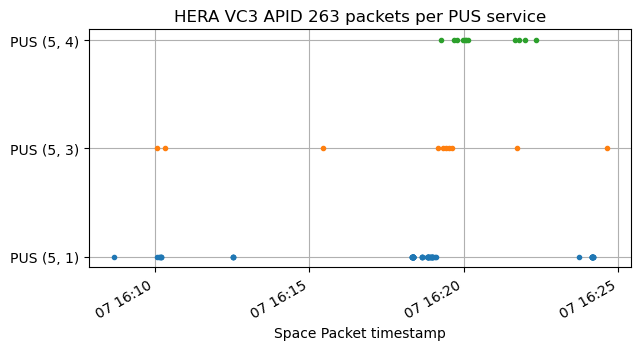

In [153]:
plot_pus_service_vc3(263)

In [154]:
vc3_pus_by_apid[263]

[Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=510, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=608, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=3, message_type_counter=11, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=615, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=616, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=617, destination_id=0),
 Container(version_number=2, spacecraft_time_reference_status=0, service_type=5, message_subtype=1, message_type_counter=618, desti

In [155]:
# note that event ID 0x0105 gives the same data as TM[12,12]
[a[source_data_offset:-2].hex() for a in vc3_by_apid[263]]

['02a30400',
 '01f9000000c8',
 '0196',
 '01570102',
 '01530102',
 '010502e513280000000000000000ff00000000000000000000000000000000020000007f8e091b3f',
 '010502e613270000000000000000ff00000000000000000000000000000000020000007f8e091cb0',
 '010502e713260000000000000000ff00000000000000000000000000000000020000007f8e091dee',
 '019c',
 '01050418334201ffffffffffffffff403601d3e0000000000000000000000002000000801d095619',
 '0105041e422501ffffffffffffffff4034930d3ccccccd000000000000000002000000801d0959e6',
 '0105045d331f01ffffffffffffffff3fcee7f1930294eb000000000000000002000000801d09785f',
 '0105045f331101ffffffffffffffff3ff4814d25eb87c4000000000000000002000000801d097a02',
 '01a6',
 '010500012c8e0000000000000000ff0000000000000001000000000000000103000000817f08a19c',
 '0105001f118f0000000000000000ff0000000000000001000000000000000102000000817f08cb8e',
 '03e8002111910000000000000000ff0000000000000000000000000000000102030000817f08dfde',
 '03e8002311bd01ffffffffffffffff00000000000000000000000000000001020

# VC7

VC7 is the idle APID. The payload of the frames is filled by a PN9 sequence in the same [way as for BepiColombo](https://destevez.net/2020/04/idle-data-in-bepicolombo-x-band-signal/) and JUICE.

In [156]:
vc7_frames = frames[vcid == 7]

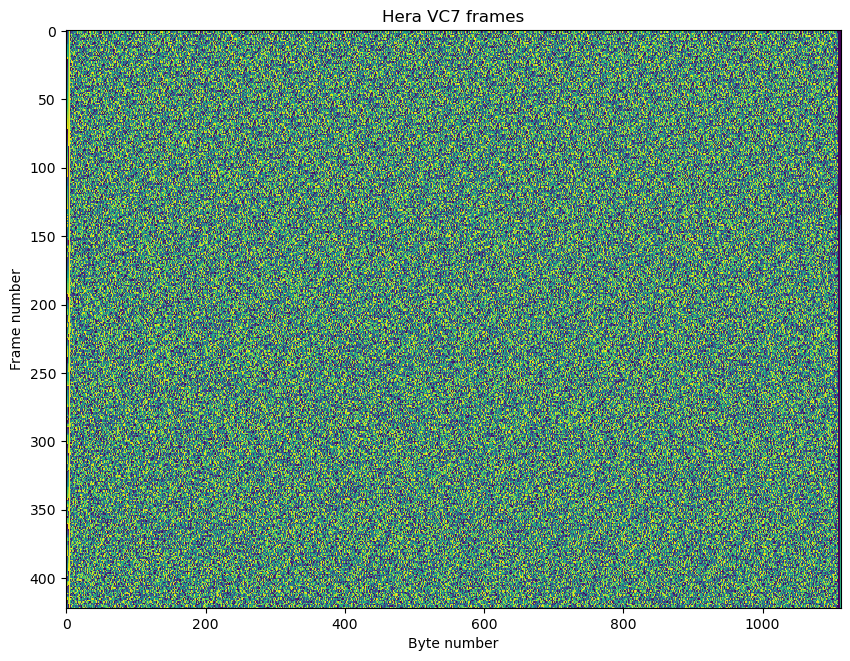

In [157]:
plt.figure(figsize=(10, 7.5))
plt.imshow(vc7_frames, aspect='auto', interpolation='none')
plt.title('Hera VC7 frames')
plt.xlabel('Byte number')
plt.ylabel('Frame number');

In [158]:
lfsr = np.ones(9, dtype = 'uint8')
lfsr_out = np.empty(511, dtype = 'uint8')
for j in range(lfsr_out.size):
    out = lfsr[8] ^ lfsr[4]
    lfsr_out[j] = lfsr[8]
    lfsr = np.roll(lfsr, 1)
    lfsr[0] = out
    
def gen_idle_payload(vcfc):
    framebits = 8824
    start = (framebits * vcfc) % lfsr_out.size
    lfsr_out_repeat = np.tile(lfsr_out, int(np.ceil(framebits / lfsr_out.size)) + 2)
    return bytes(np.packbits(lfsr_out_repeat[start:start+framebits]))

for frame in tm:
    if frame.primary_header.virtual_channel_id == 7:
        assert frame.m_pdu_packet_zone == gen_idle_payload(frame.primary_header.virtual_channel_frame_count)

# CLCW

In [159]:
clcw = [a.clcw for a in tm]

In [160]:
clcw[:4]

[Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=1, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=True, wait=False, retransmit=False, farm_b_counter=1, rsvd_spare2=0, report_value=0),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=1, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=True, wait=False, retransmit=False, farm_b_counter=1, rsvd_spare2=0, report_value=0),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=1, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=True, wait=False, retransmit=False, farm_b_counter=1, rsvd_spare2=0, report_value=0),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=1, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, loc

In [161]:
collections.Counter([(c.control_word_type, c.clcw_version_number, c.status_field, c.cop_in_effect,
                      c.virtual_channel_identification, c.no_bit_lock, c.no_rf_avail,
                      c.rsvd_spare, c.rsvd_spare2, c.retransmit, c.wait)
                     for c in clcw])

Counter({(False, 0, 0, 1, 1, False, False, 0, 0, False, False): 3039})

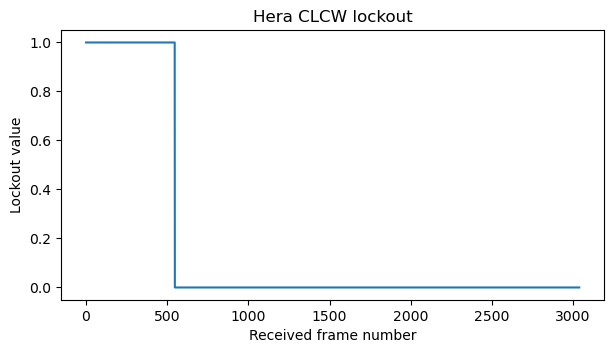

In [162]:
plt.plot([c.lock_out for c in clcw])
plt.title('Hera CLCW lockout')
plt.ylabel('Lockout value')
plt.xlabel('Received frame number');

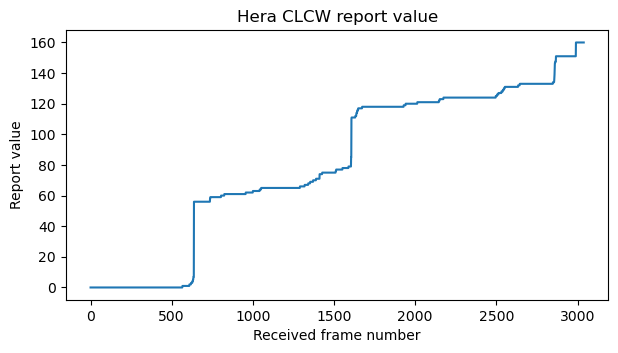

In [163]:
plt.plot([c.report_value for c in clcw])
plt.title('Hera CLCW report value')
plt.ylabel('Report value')
plt.xlabel('Received frame number');

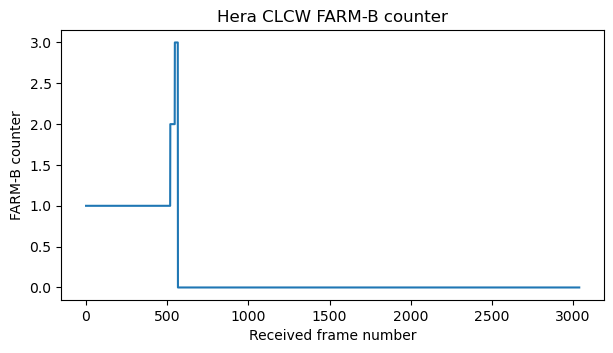

In [164]:
plt.plot([c.farm_b_counter for c in clcw])
plt.title('Hera CLCW FARM-B counter')
plt.ylabel('FARM-B counter')
plt.xlabel('Received frame number');